## Initial Visualiation using 2 random inputs

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cuda


(500, 32, 32)


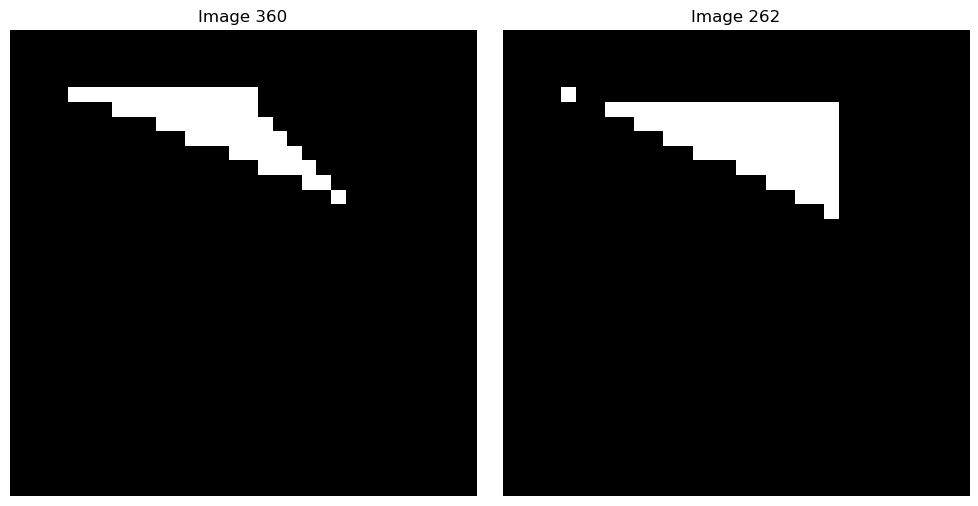

In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64

imageType = "shapes_3_dims_24_4" #10x10 triangle in 16x16 matrix shapes_3_dims_10_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5

#percentage = 0.41
# imageSet = utils.generate_filtered_image_set(imageType, filters, Futils.get_image_set_filepath(imageType, filters))
# imageSet = np.array(imageSet)

# sampleName = f"{imageType} {filters} {percentage} sample"

# sampleEstimator = SampleEstimator(sampleName=sampleName, embeddingType=embeddingType, imageProductType=imageProductType)
# #print(len(sampleEstimator.trainingImageSet))
# testSample = np.array([img for img in imageSet if not np.any([np.array_equal(img, train_img) for train_img in sampleEstimator.trainingImageSet])])
# #brute force one more image for dimension 128 T-T
# # testSample = np.append(testSample, [sampleEstimator.trainingImageSet[50]], axis=0)
testSample = np.load('/home/jovyan/VecRepV3/data/test_images_32x32.npy')
print(testSample.shape)
index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
# index1 = 182
# index2 = 305
input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

In [4]:
model = models.SimpleCNN2(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_2", 
                                              f'best_model_{imageType}_{dimensions}d_convlayer1.pt')))
model.eval()

/tmp/ipykernel_12572/2542937459.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/m

SimpleCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=64, bias=True)
)

## Visualisation of Loss score calculation -- Metric 1

In [5]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("Difference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.6003621816635132
Dot product value of model:  0.1176641508936882
Loss:  0.4826980233192444

Dot product value of BF Method:  0.6857084975375175
Loss:  0.08534634113311768
Difference in values of BF Method and Model Method:  0.5680443644523621


## Visualisation of KNN-IoU K score calculation -- Metric 2

----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 360: K-Score = 0.7142857142857143
Intersection sets : [ 32 205 250 360 495]
Union sets: [ 32  34 205 250 274 360 495]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   360                    1.000000                            1.000000
    32                    0.730680                            0.831320
    34                    0.651793                            0.760618
   205                    0.776433                            0.847229
   250                    0.703054                            0.776523
   274                    0.686599                            0.734627
   495                    0.732787                            0.821672

Comparing images in intersection & union sets

Plotting images in the intersection set:


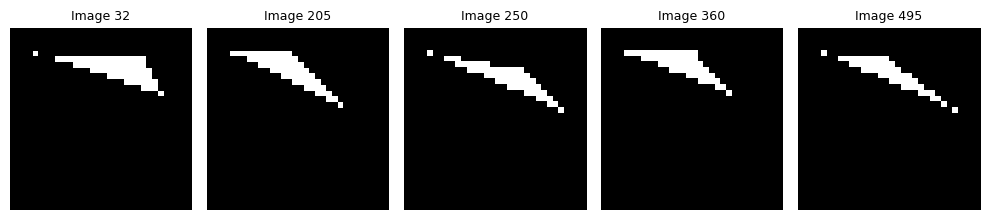


Plotting images in the union set:


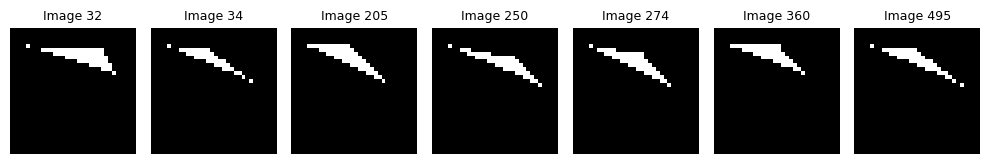


For translationally unique plots: 
Image 32 has no translationally similar images.
Image 34 has no translationally similar images.
Image 205 has no translationally similar images.
Image 250 has no translationally similar images.
Image 274 has no translationally similar images.
Image 360 has no translationally similar images.
Image 495 has no translationally similar images.

Plotting images in the intersection set:


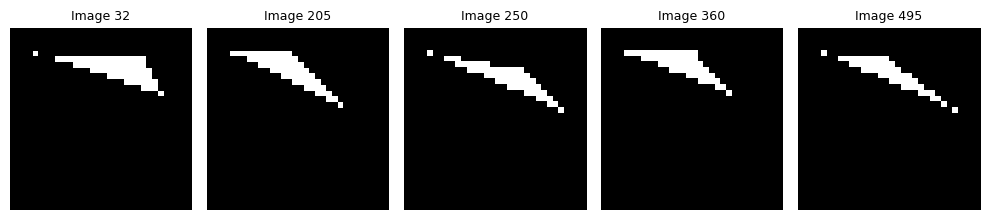


Plotting images in the union set:


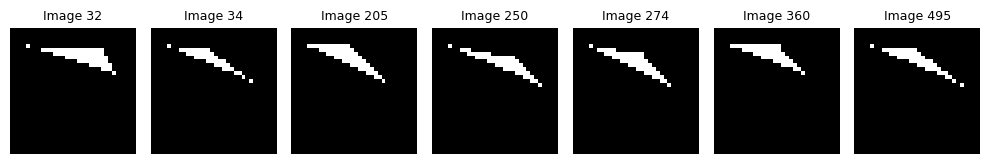


Top 21 values of Vector b
Rank 1: Value = 1.0, Index = 360
Rank 2: Value = 0.7764331102371216, Index = 205
Rank 3: Value = 0.7327874898910522, Index = 495
Rank 4: Value = 0.7306803464889526, Index = 32
Rank 5: Value = 0.7030537128448486, Index = 250
Rank 6: Value = 0.6865987777709961, Index = 274
Rank 7: Value = 0.6586275100708008, Index = 76
Rank 8: Value = 0.6517932415008545, Index = 34
Rank 9: Value = 0.6517932415008545, Index = 197
Rank 10: Value = 0.639057993888855, Index = 127
Rank 11: Value = 0.6263456344604492, Index = 319
Rank 12: Value = 0.6012815237045288, Index = 136
Rank 13: Value = 0.6003620624542236, Index = 262
Rank 14: Value = 0.5787044763565063, Index = 171
Rank 15: Value = 0.5711685419082642, Index = 498
Rank 16: Value = 0.5689290761947632, Index = 198
Rank 17: Value = 0.5677602291107178, Index = 352
Rank 18: Value = 0.5550838708877563, Index = 242
Rank 19: Value = 0.5527918338775635, Index = 12
Rank 20: Value = 0.5430066585540771, Index = 29
Rank 21: Value = 0.5350

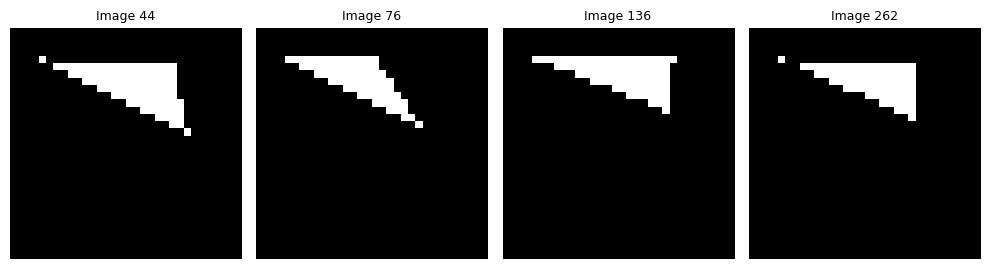


Plotting images in the union set:


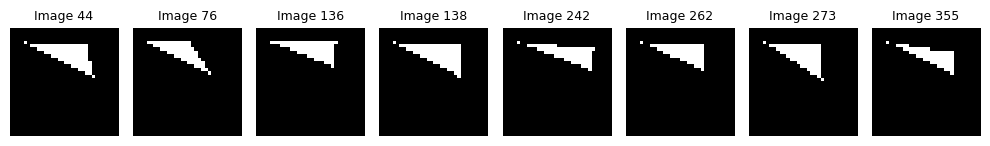


For translationally unique plots: 
Image 44 has no translationally similar images.
Image 76 has no translationally similar images.
Image 136 has no translationally similar images.
Image 138 has no translationally similar images.
Image 242 has no translationally similar images.
Image 262 has no translationally similar images.
Image 273 has no translationally similar images.
Image 355 has no translationally similar images.

Plotting images in the intersection set:


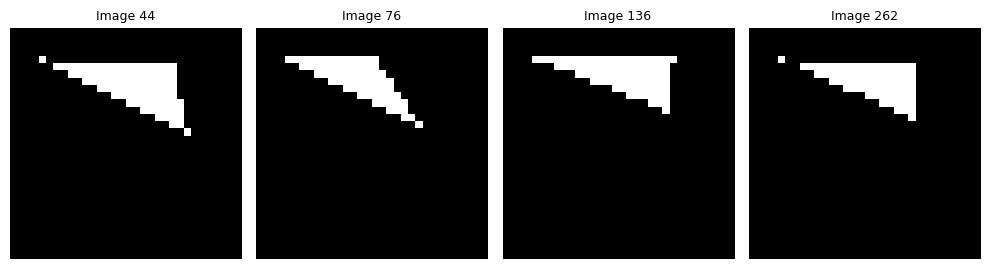


Plotting images in the union set:


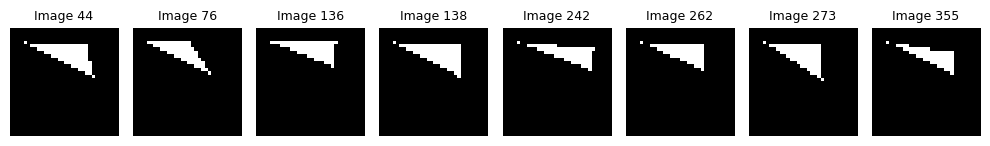


Top 21 values of Vector b
Rank 1: Value = 1.0, Index = 262
Rank 2: Value = 0.8538180589675903, Index = 136
Rank 3: Value = 0.7811272144317627, Index = 44
Rank 4: Value = 0.7548596858978271, Index = 273
Rank 5: Value = 0.7429478168487549, Index = 355
Rank 6: Value = 0.735481858253479, Index = 76
Rank 7: Value = 0.732050895690918, Index = 138
Rank 8: Value = 0.72666335105896, Index = 242
Rank 9: Value = 0.7226735353469849, Index = 356
Rank 10: Value = 0.6926735639572144, Index = 32
Rank 11: Value = 0.6926735639572144, Index = 86
Rank 12: Value = 0.6914002895355225, Index = 150
Rank 13: Value = 0.6817917823791504, Index = 467
Rank 14: Value = 0.671008825302124, Index = 27
Rank 15: Value = 0.6586495637893677, Index = 20
Rank 16: Value = 0.6557480096817017, Index = 358
Rank 17: Value = 0.6425230503082275, Index = 171
Rank 18: Value = 0.636062502861023, Index = 198
Rank 19: Value = 0.635080099105835, Index = 231
Rank 20: Value = 0.6291220188140869, Index = 417
Rank 21: Value = 0.62644076347

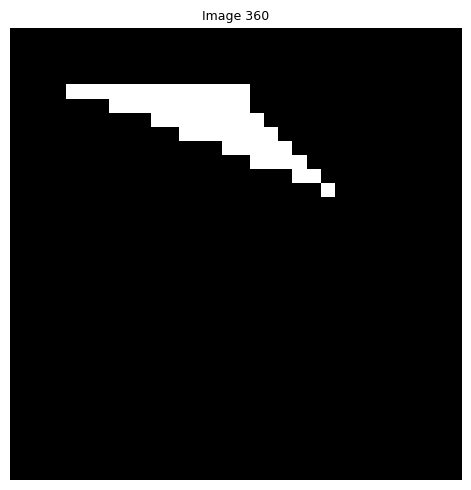


Plotting images in the union set:


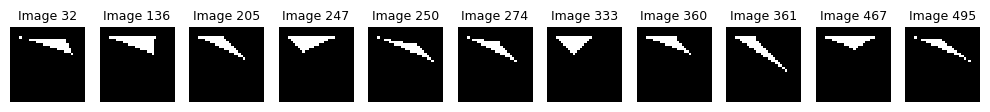


For translationally unique plots: 
Image 32 has no translationally similar images.
Image 136 has no translationally similar images.
Image 205 has no translationally similar images.
Image 247 has no translationally similar images.
Image 250 has no translationally similar images.
Image 274 has no translationally similar images.
Image 333 has no translationally similar images.
Image 360 has no translationally similar images.
Image 361 has no translationally similar images.
Image 467 has no translationally similar images.
Image 495 has no translationally similar images.

Plotting images in the intersection set:


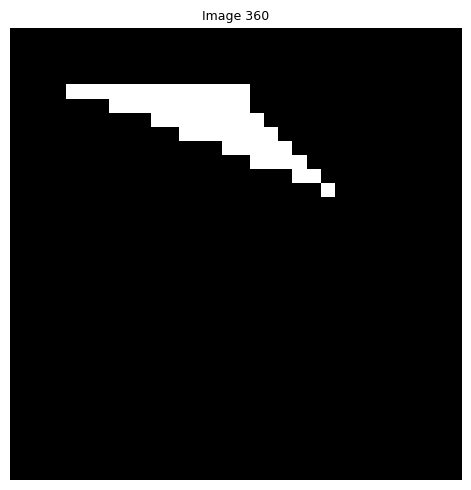


Plotting images in the union set:


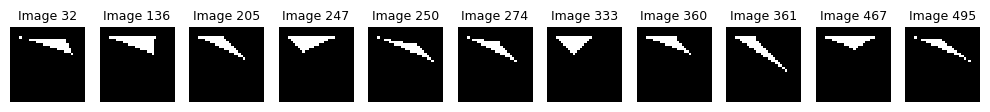

Estimating K-Score for Image 262: K-Score = 0.3333333333333333
Intersection sets : [ 44 262 273]
Union sets: [ 44  76 136 138 189 242 262 273 355]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   262                    1.000000                            1.000000
    44                    0.781127                            0.864376
    76                    0.735482                            0.584764
   136                    0.853818                            0.488998
   138                    0.732051                            0.824487
   189                    0.468418                            0.793605
   242                    0.726663                            0.794953
   273                    0.754860                            0.813563
   355                    0.742948                            0.681875

Comparing images in intersection & union sets

Plotting images in the intersection set:


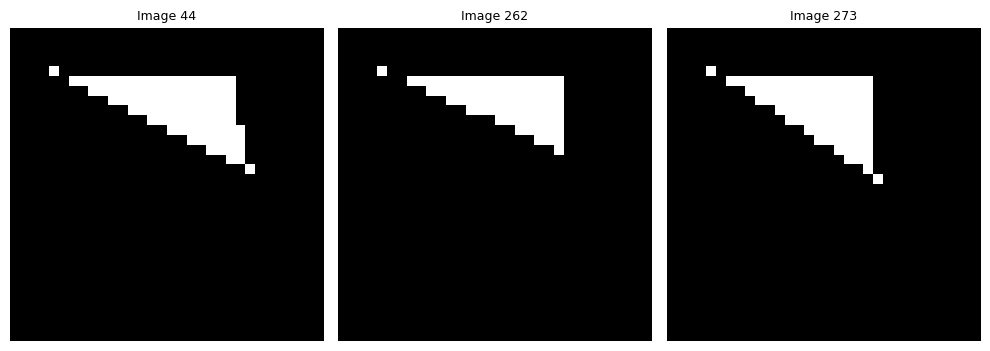


Plotting images in the union set:


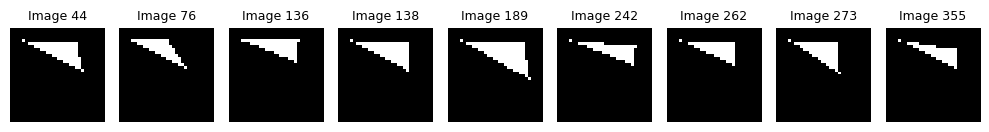


For translationally unique plots: 
Image 44 has no translationally similar images.
Image 76 has no translationally similar images.
Image 136 has no translationally similar images.
Image 138 has no translationally similar images.
Image 189 has no translationally similar images.
Image 242 has no translationally similar images.
Image 262 has no translationally similar images.
Image 273 has no translationally similar images.
Image 355 has no translationally similar images.

Plotting images in the intersection set:


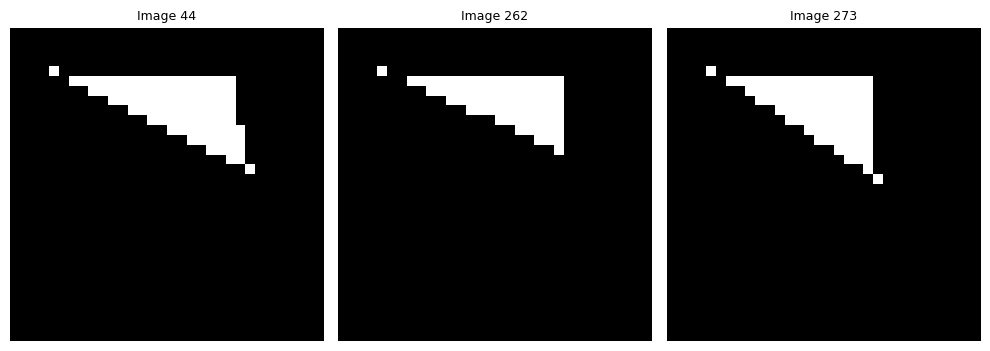


Plotting images in the union set:


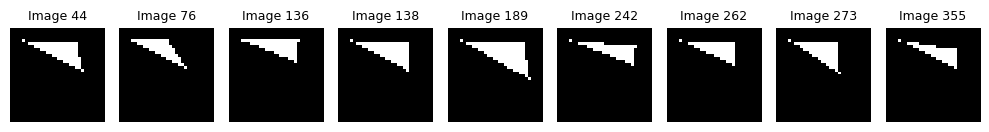

(array([ 44, 262, 273]), [44, 76, 136, 138, 189, 242, 262, 273, 355])

In [6]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)


NCC Interval		Average Loss
-0.1-0.0		0.2645 (17037 samples)
-0.2--0.1		0.2606 (21981 samples)
-0.3--0.2		0.2618 (9175 samples)
-0.4--0.3		0.3704 (4880 samples)
-0.5--0.4		0.5008 (3318 samples)
-0.6--0.5		0.3782 (1700 samples)
-0.7--0.6		0.5044 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2980 (31235 samples)
0.1-0.2		0.2965 (19574 samples)
0.2-0.3		0.3026 (15980 samples)
0.3-0.4		0.2570 (9036 samples)
0.4-0.5		0.2573 (6081 samples)
0.5-0.6		0.2223 (3692 samples)
0.6-0.7		0.1907 (1907 samples)
0.7-0.8		0.1851 (956 samples)
0.8-0.9		0.1293 (344 samples)
0.9-1.0		0.0051 (430 samples)


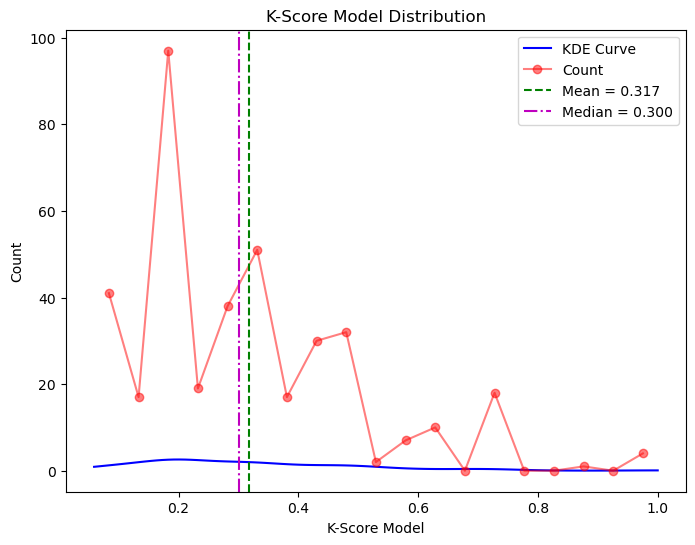

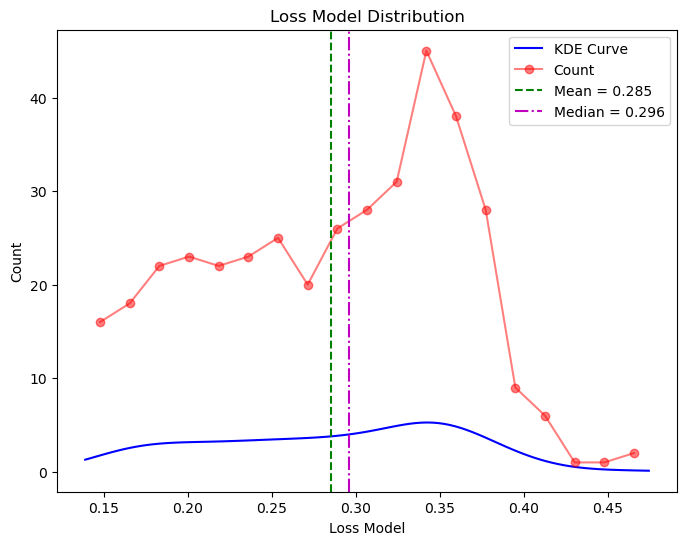


NCC Interval		Average Loss
-0.1-0.0		0.0553 (17037 samples)
-0.2--0.1		0.0673 (21981 samples)
-0.3--0.2		0.0755 (9175 samples)
-0.4--0.3		0.0981 (4880 samples)
-0.5--0.4		0.1843 (3318 samples)
-0.6--0.5		0.2047 (1700 samples)
-0.7--0.6		0.2432 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0580 (31235 samples)
0.1-0.2		0.0623 (19574 samples)
0.2-0.3		0.0646 (15980 samples)
0.3-0.4		0.0732 (9036 samples)
0.4-0.5		0.0676 (6081 samples)
0.5-0.6		0.0709 (3692 samples)
0.6-0.7		0.0685 (1907 samples)
0.7-0.8		0.0690 (956 samples)
0.8-0.9		0.0582 (344 samples)
0.9-1.0		0.0032 (430 samples)


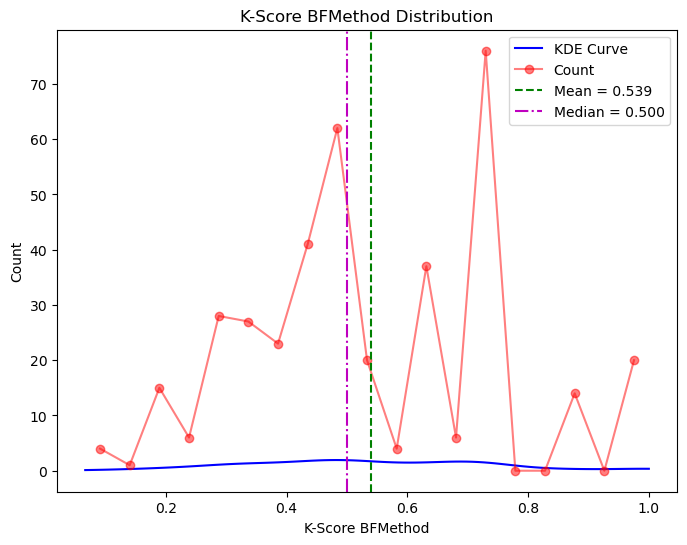

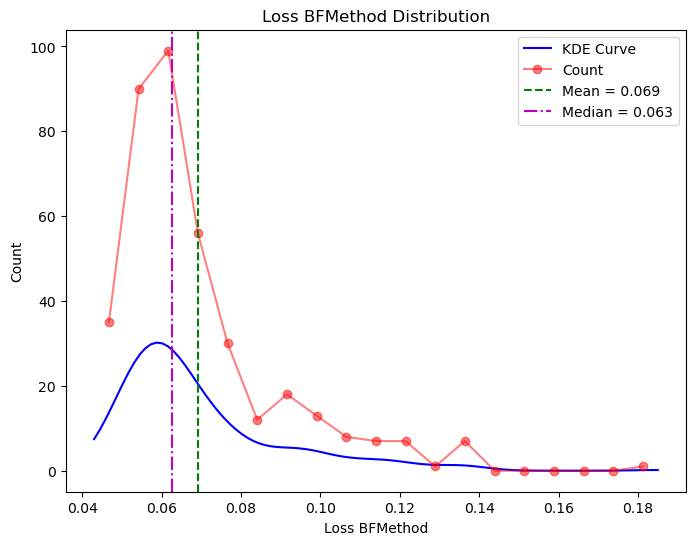

In [6]:
#--------------------Visualisation of loss and k-score across dataset using model and Pencorr-------------------
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score Model")
imgplt.plot_score_distribution(losses, "Loss Model")

kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
imgplt.plot_score_distribution(losses, "Loss BFMethod")

## Metric 1 & 2: Loss and K-Score calculation
### Visualisation of loss and k-score across dataset across dimensions

Dimension 32

NCC Interval		Average Loss
-0.1-0.0		0.3537 (20747 samples)
-0.2--0.1		0.4163 (22128 samples)
-0.3--0.2		0.4676 (21715 samples)
-0.4--0.3		0.5288 (22575 samples)
-0.5--0.4		0.5966 (21477 samples)
-0.6--0.5		0.6460 (18532 samples)
-0.7--0.6		0.7069 (11984 samples)
-0.8--0.7		0.8168 (4692 samples)
-0.9--0.8		0.8921 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.3116 (21562 samples)
0.1-0.2		0.2667 (20116 samples)
0.2-0.3		0.2324 (18407 samples)
0.3-0.4		0.1984 (14862 samples)
0.4-0.5		0.1821 (12001 samples)
0.5-0.6		0.1602 (8923 samples)
0.6-0.7		0.1403 (5511 samples)
0.7-0.8		0.1215 (2747 samples)
0.8-0.9		0.1201 (800 samples)
0.9-1.0		0.0183 (588 samples)


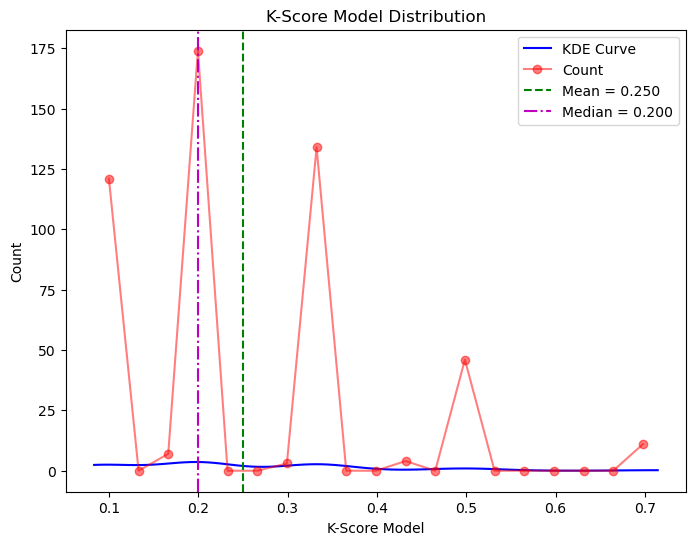

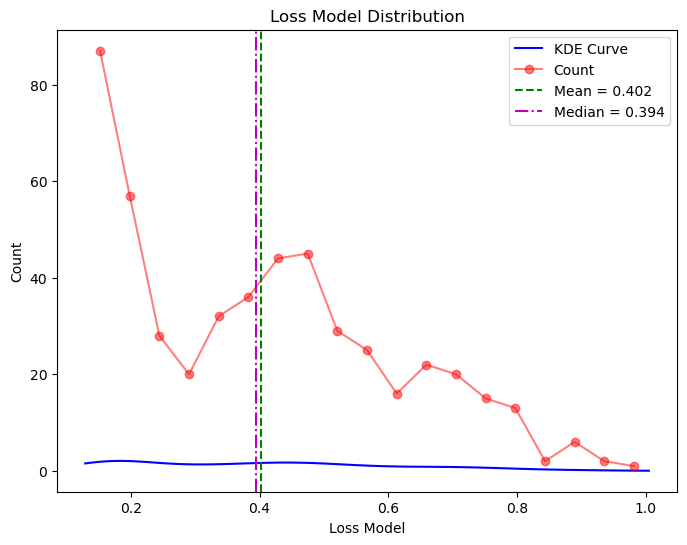


NCC Interval		Average Loss
-0.1-0.0		0.0966 (20747 samples)
-0.2--0.1		0.1186 (22128 samples)
-0.3--0.2		0.1412 (21715 samples)
-0.4--0.3		0.1722 (22575 samples)
-0.5--0.4		0.2140 (21477 samples)
-0.6--0.5		0.2689 (18532 samples)
-0.7--0.6		0.3401 (11984 samples)
-0.8--0.7		0.4229 (4692 samples)
-0.9--0.8		0.5167 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0836 (21562 samples)
0.1-0.2		0.0749 (20116 samples)
0.2-0.3		0.0688 (18407 samples)
0.3-0.4		0.0674 (14862 samples)
0.4-0.5		0.0730 (12001 samples)
0.5-0.6		0.0912 (8923 samples)
0.6-0.7		0.1139 (5511 samples)
0.7-0.8		0.1264 (2747 samples)
0.8-0.9		0.1119 (800 samples)
0.9-1.0		0.0094 (588 samples)


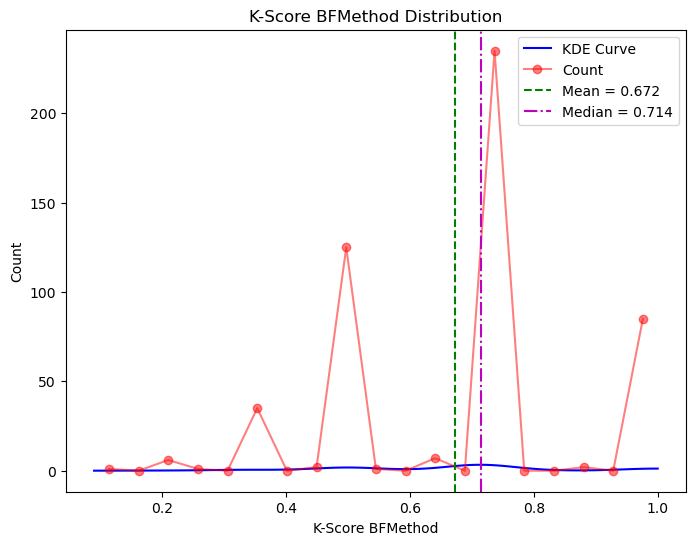

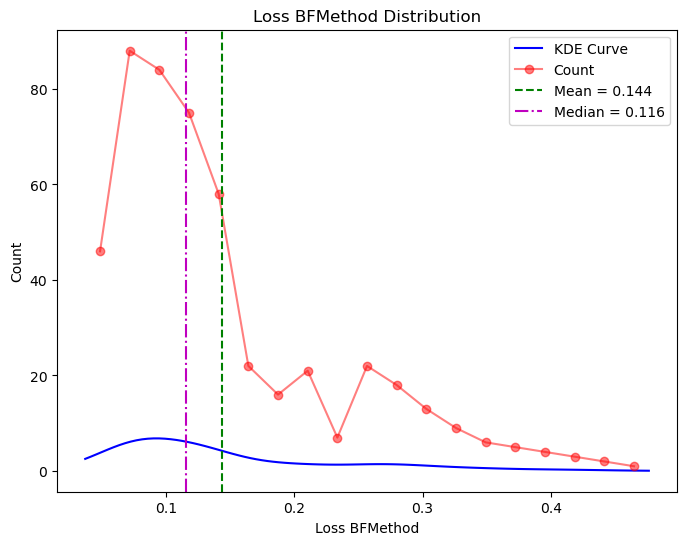

Dimension 64

NCC Interval		Average Loss
-0.1-0.0		0.2397 (20747 samples)
-0.2--0.1		0.2570 (22128 samples)
-0.3--0.2		0.2676 (21715 samples)
-0.4--0.3		0.2979 (22575 samples)
-0.5--0.4		0.3518 (21477 samples)
-0.6--0.5		0.3988 (18532 samples)
-0.7--0.6		0.4576 (11984 samples)
-0.8--0.7		0.5285 (4692 samples)
-0.9--0.8		0.5926 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2452 (21562 samples)
0.1-0.2		0.2491 (20116 samples)
0.2-0.3		0.2556 (18407 samples)
0.3-0.4		0.2601 (14862 samples)
0.4-0.5		0.2498 (12001 samples)
0.5-0.6		0.2270 (8923 samples)
0.6-0.7		0.1904 (5511 samples)
0.7-0.8		0.1386 (2747 samples)
0.8-0.9		0.0949 (800 samples)
0.9-1.0		0.0112 (588 samples)


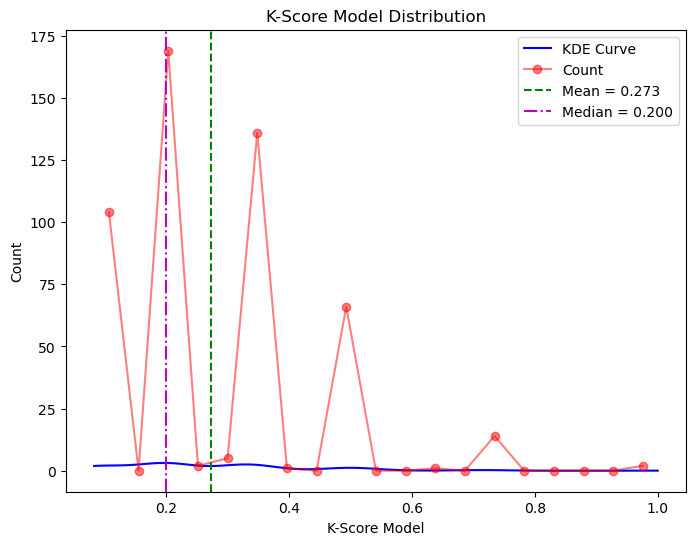

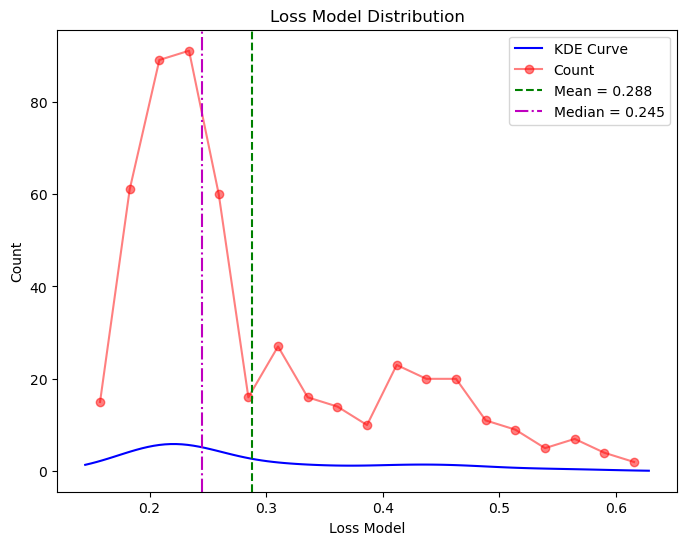


NCC Interval		Average Loss
-0.1-0.0		0.0977 (20747 samples)
-0.2--0.1		0.1211 (22128 samples)
-0.3--0.2		0.1440 (21715 samples)
-0.4--0.3		0.1754 (22575 samples)
-0.5--0.4		0.2187 (21477 samples)
-0.6--0.5		0.2741 (18532 samples)
-0.7--0.6		0.3452 (11984 samples)
-0.8--0.7		0.4293 (4692 samples)
-0.9--0.8		0.5216 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0830 (21562 samples)
0.1-0.2		0.0716 (20116 samples)
0.2-0.3		0.0642 (18407 samples)
0.3-0.4		0.0586 (14862 samples)
0.4-0.5		0.0564 (12001 samples)
0.5-0.6		0.0622 (8923 samples)
0.6-0.7		0.0747 (5511 samples)
0.7-0.8		0.0924 (2747 samples)
0.8-0.9		0.0927 (800 samples)
0.9-1.0		0.0084 (588 samples)


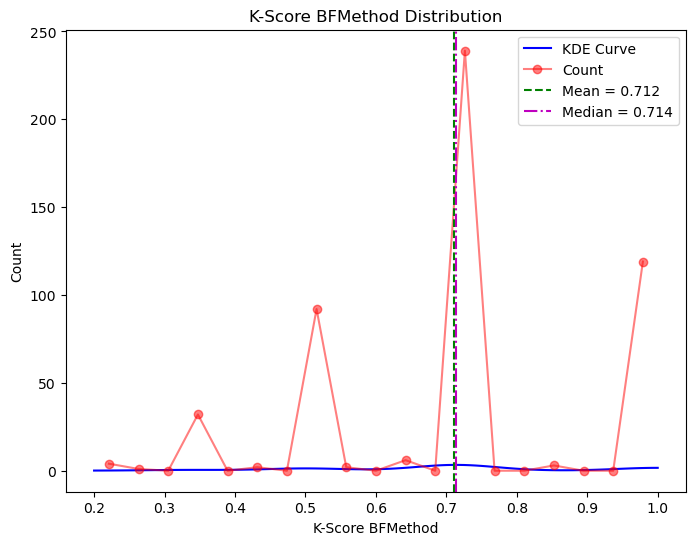

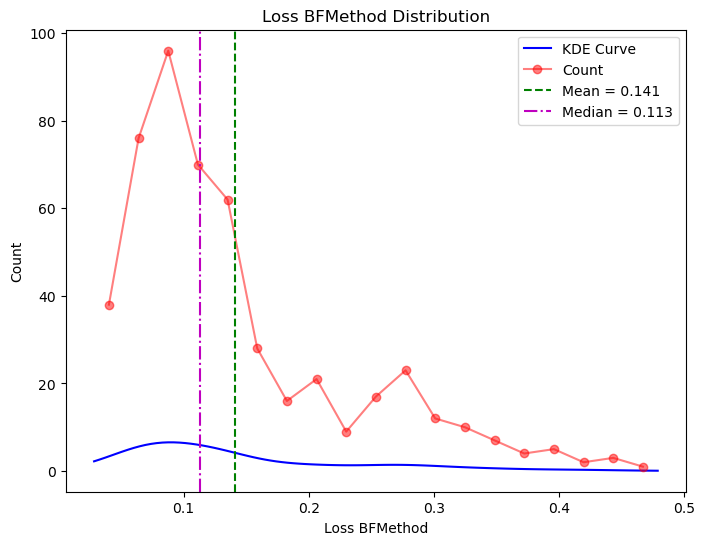

Dimension 128

NCC Interval		Average Loss
-0.1-0.0		0.2586 (20747 samples)
-0.2--0.1		0.2830 (22128 samples)
-0.3--0.2		0.2998 (21715 samples)
-0.4--0.3		0.3294 (22575 samples)
-0.5--0.4		0.3804 (21477 samples)
-0.6--0.5		0.4183 (18532 samples)
-0.7--0.6		0.4836 (11984 samples)
-0.8--0.7		0.5657 (4692 samples)
-0.9--0.8		0.6003 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2443 (21562 samples)
0.1-0.2		0.2348 (20116 samples)
0.2-0.3		0.2287 (18407 samples)
0.3-0.4		0.2244 (14862 samples)
0.4-0.5		0.2112 (12001 samples)
0.5-0.6		0.1906 (8923 samples)
0.6-0.7		0.1542 (5511 samples)
0.7-0.8		0.1196 (2747 samples)
0.8-0.9		0.0939 (800 samples)
0.9-1.0		0.0135 (588 samples)


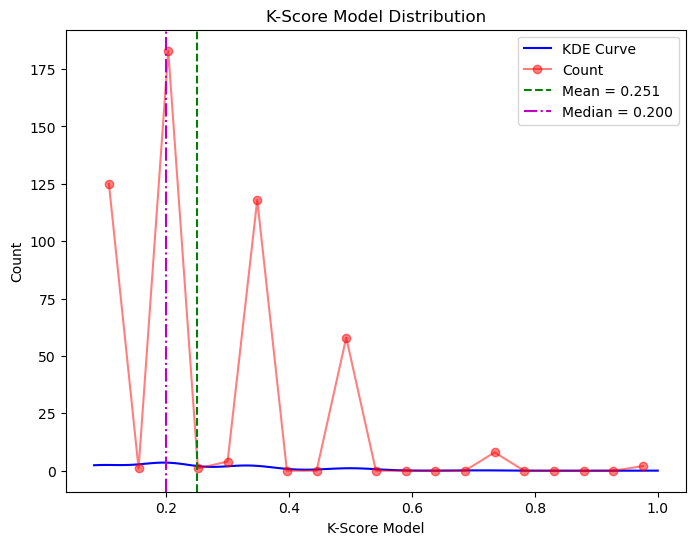

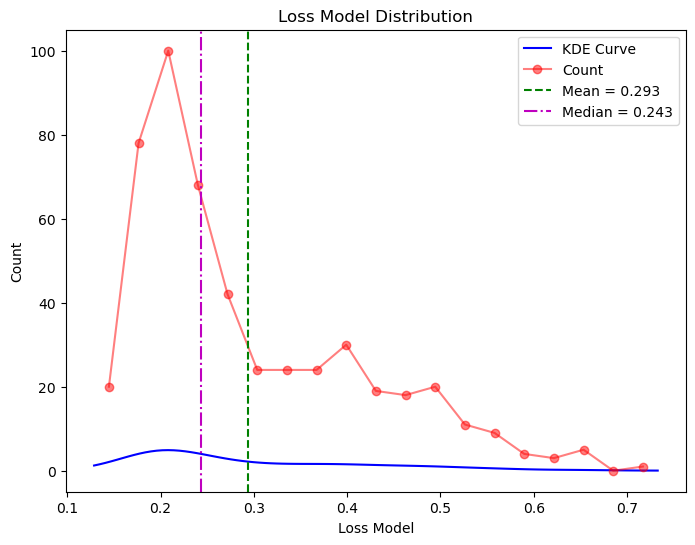


NCC Interval		Average Loss
-0.1-0.0		0.0983 (20747 samples)
-0.2--0.1		0.1218 (22128 samples)
-0.3--0.2		0.1449 (21715 samples)
-0.4--0.3		0.1765 (22575 samples)
-0.5--0.4		0.2200 (21477 samples)
-0.6--0.5		0.2754 (18532 samples)
-0.7--0.6		0.3465 (11984 samples)
-0.8--0.7		0.4311 (4692 samples)
-0.9--0.8		0.5229 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0833 (21562 samples)
0.1-0.2		0.0714 (20116 samples)
0.2-0.3		0.0638 (18407 samples)
0.3-0.4		0.0576 (14862 samples)
0.4-0.5		0.0541 (12001 samples)
0.5-0.6		0.0548 (8923 samples)
0.6-0.7		0.0567 (5511 samples)
0.7-0.8		0.0647 (2747 samples)
0.8-0.9		0.0685 (800 samples)
0.9-1.0		0.0069 (588 samples)


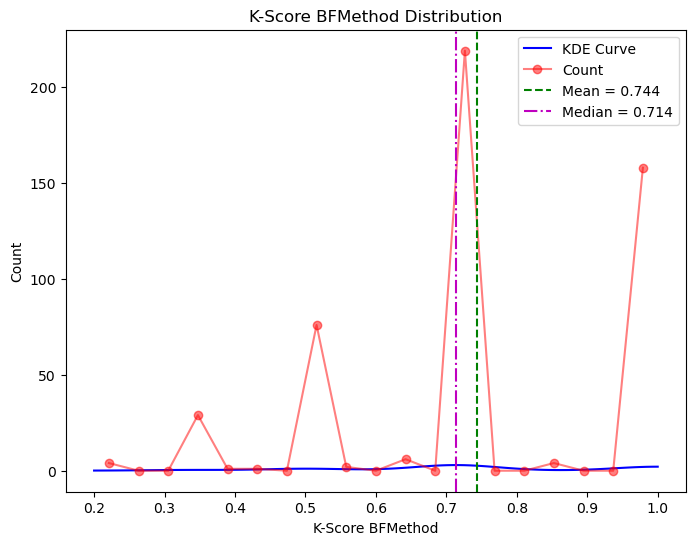

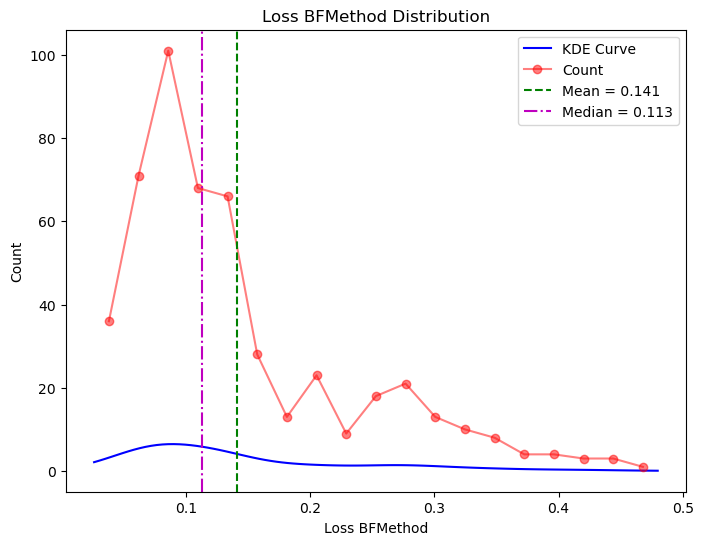

Dimension 256

NCC Interval		Average Loss
-0.1-0.0		0.2602 (20747 samples)
-0.2--0.1		0.2837 (22128 samples)
-0.3--0.2		0.3012 (21715 samples)
-0.4--0.3		0.3246 (22575 samples)
-0.5--0.4		0.3716 (21477 samples)
-0.6--0.5		0.4181 (18532 samples)
-0.7--0.6		0.4870 (11984 samples)
-0.8--0.7		0.5655 (4692 samples)
-0.9--0.8		0.6126 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2532 (21562 samples)
0.1-0.2		0.2555 (20116 samples)
0.2-0.3		0.2547 (18407 samples)
0.3-0.4		0.2549 (14862 samples)
0.4-0.5		0.2375 (12001 samples)
0.5-0.6		0.2187 (8923 samples)
0.6-0.7		0.1852 (5511 samples)
0.7-0.8		0.1360 (2747 samples)
0.8-0.9		0.0954 (800 samples)
0.9-1.0		0.0154 (588 samples)


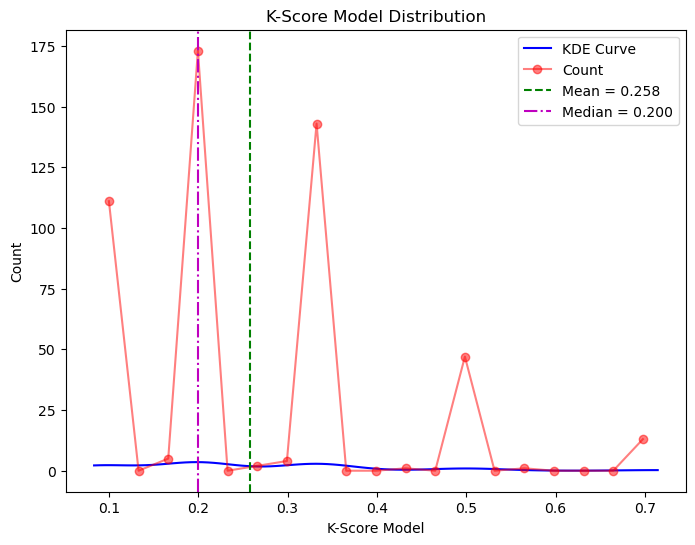

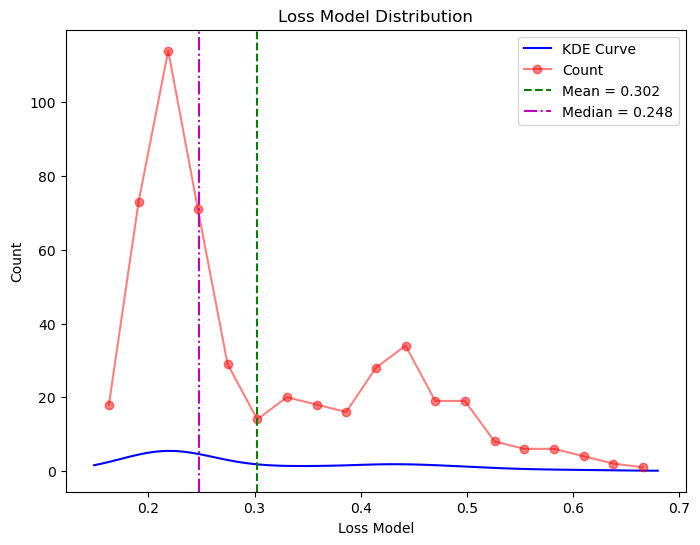

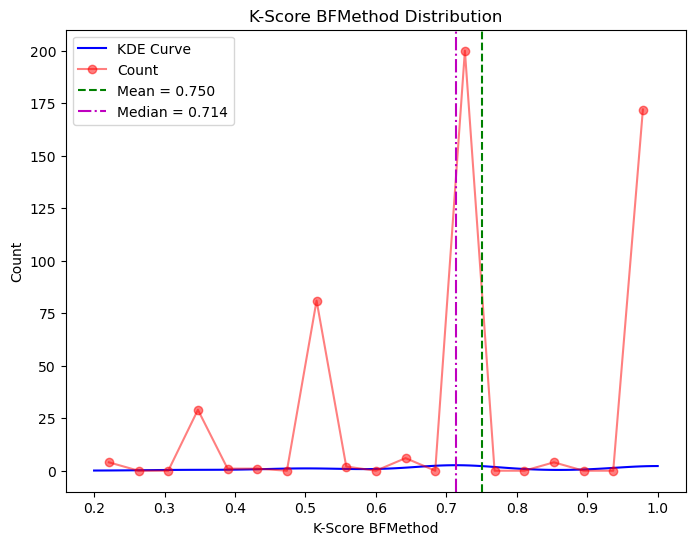

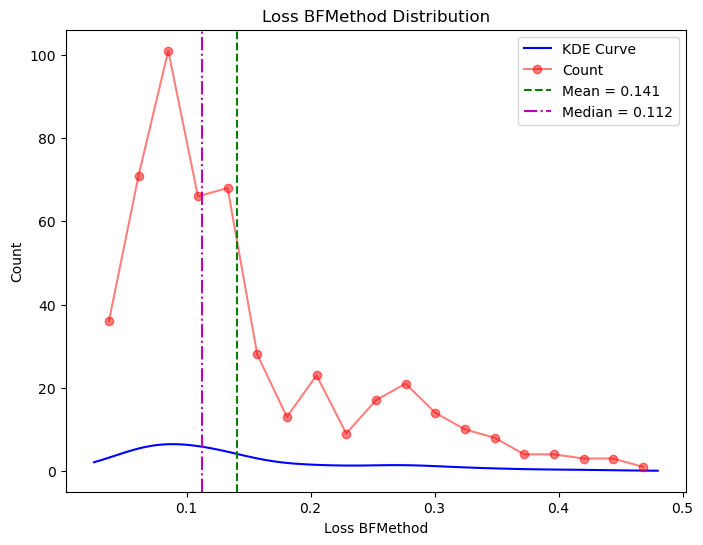

[0.250401776001776, 0.273080303030303, 0.2510982683982684, 0.25750476190476196]
[0.40173824894064664, 0.2875432292034626, 0.29343192458370326, 0.30203324939696496]


In [7]:
#--------------------Visualisation of loss and k-score across dataset across dimensions-------------------
dimensions = [32, 64, 128, 256]
mean = []
k_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:
    print(f"Dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

    imgcalc.loss_per_ncc_score(ncc_loss_dict)
    imgplt.plot_score_distribution(kscores, "K-Score Model")
    imgplt.plot_score_distribution(losses, "Loss Model")
    mean.append(np.mean(losses))
    k_score.append(np.mean(kscores))
    if dim <= len(testSample):
        matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
        kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

        imgcalc.loss_per_ncc_score(ncc_loss_dict)
        imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
        imgplt.plot_score_distribution(losses, "Loss BFMethod")
        
print(k_score)
print(mean)

### Visualisation of Mean Squared Difference of original vector embeddings of sampled images

In [7]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_2", 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.040355348892248975

Mean Squared Difference of Model and NCC (G): 0.15453794308350874
Mean Squared Difference of Model and Pencorr (A'A): 0.08857968425691441

Printing matrices

Matrix G: [[ 1.         -0.65184468 -0.47018713 ... -0.75520396 -0.64365166
  -0.61025807]
 [-0.65184468  1.         -0.30828559 ... -0.16903645  0.2561537
   0.15337098]
 [-0.47018713 -0.30828559  1.         ... -0.51363957  0.27438617
  -0.53539678]
 ...
 [-0.75520396 -0.16903645 -0.51363957 ...  1.         -0.08405721
  -0.09363103]
 [-0.64365166  0.2561537   0.27438617 ... -0.08405721  1.
  -0.13197589]
 [-0.61025807  0.15337098 -0.53539678 ... -0.09363103 -0.13197589
   1.        ]]

Matrix A'A (Pencorr): [[ 1.         -0.40385153  0.17631002 ... -0.42973586 -0.42813806
  -0.22991002]
 [-0.40385153  1.         -0.15187719 ... -0.10746696  0.31210782
   0.22254778]
 [ 0.17631002 -0.15187719  1.         ... -0.2899779   0.34812124
  -0.29594212]
 ...
 [

## Visualisation of vector embeddings of similar images across dimensions 

For dimension 32
[31, 195, 112, 82, 481, 80, 341, 447, 282, 243, 393, 499, 70, 120, 377, 417, 249, 248, 474, 491, 150, 404, 251, 192]


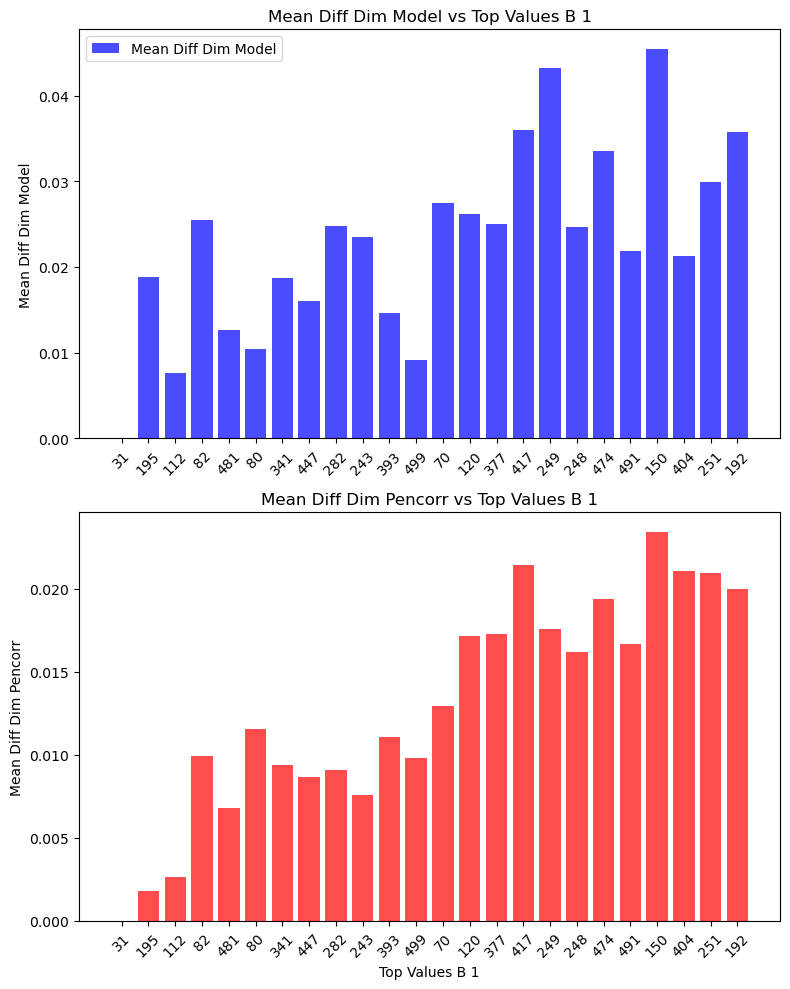

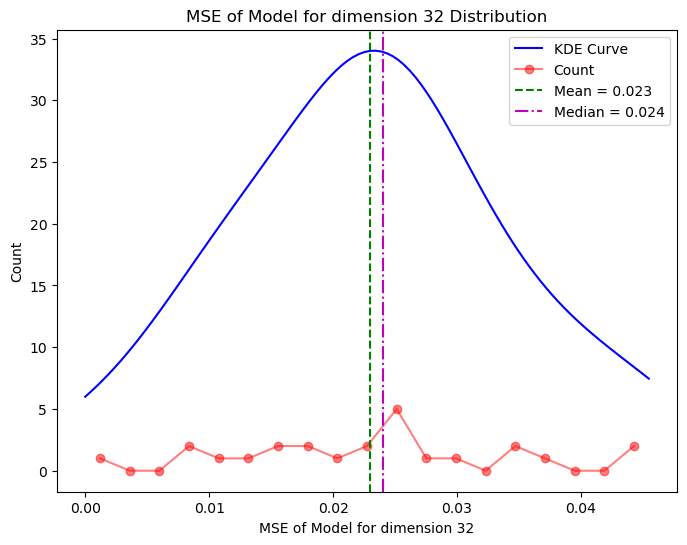

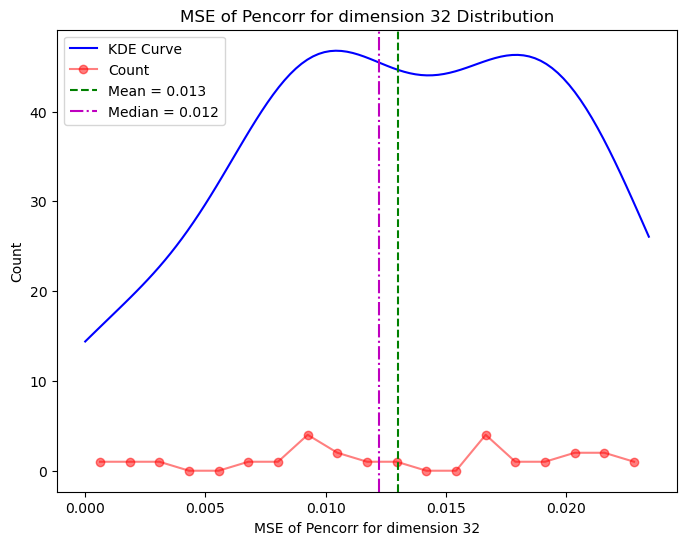

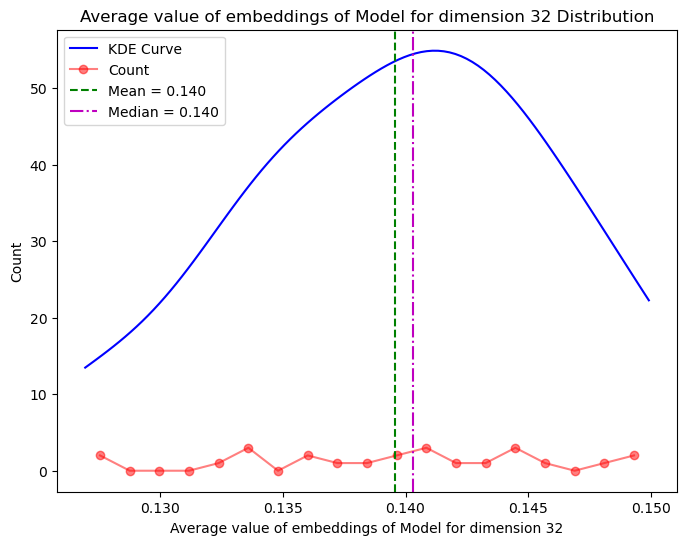

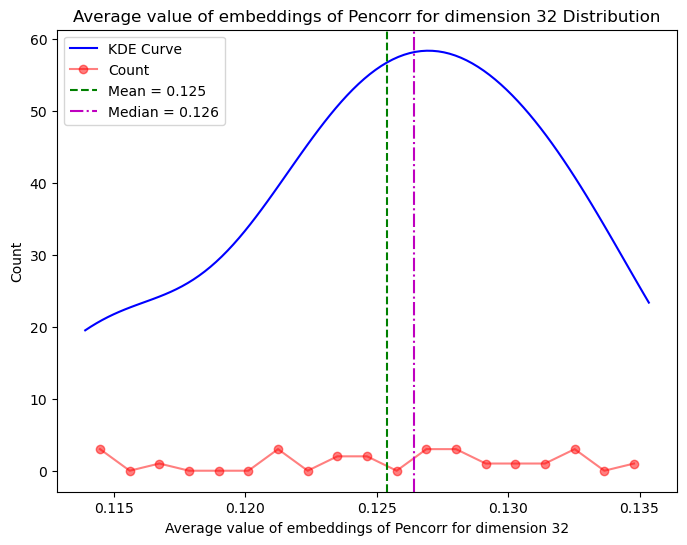

For dimension 64
[31, 195, 112, 82, 481, 80, 341, 447, 282, 243, 393, 499, 70, 120, 377, 417, 249, 248, 474, 491, 150, 404, 251, 192]


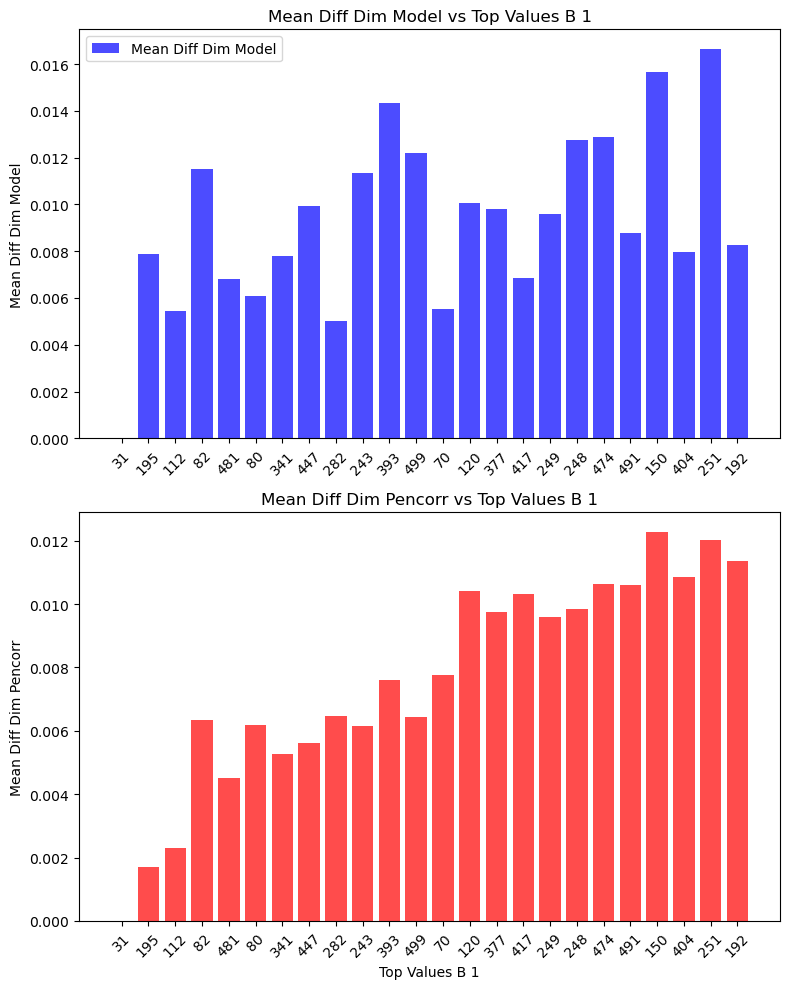

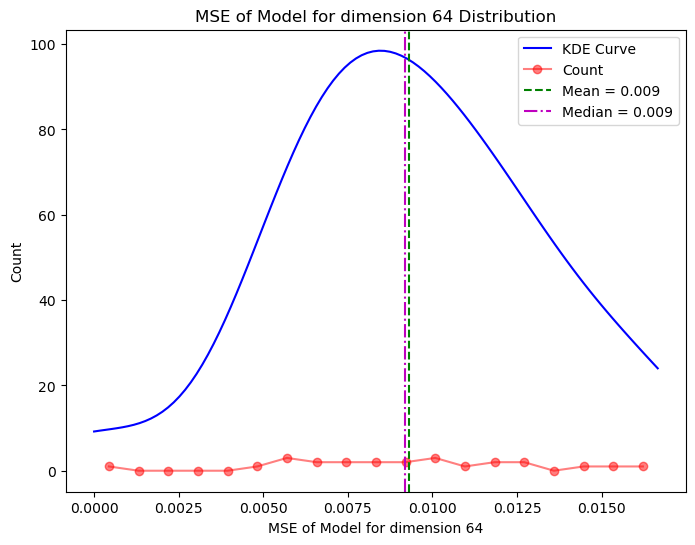

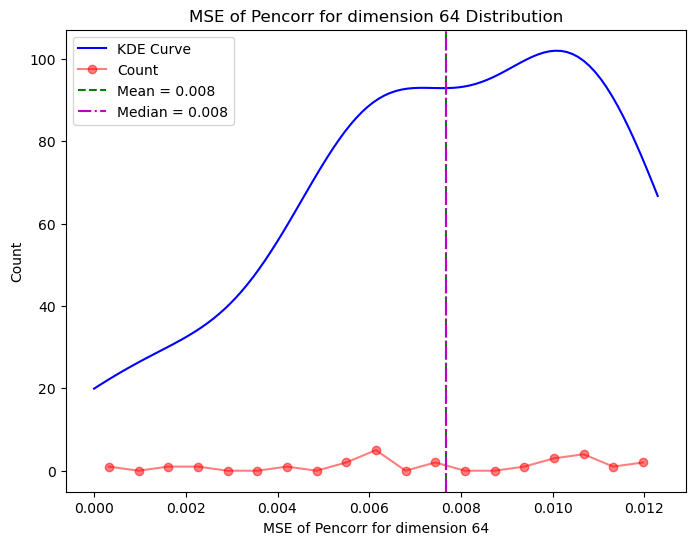

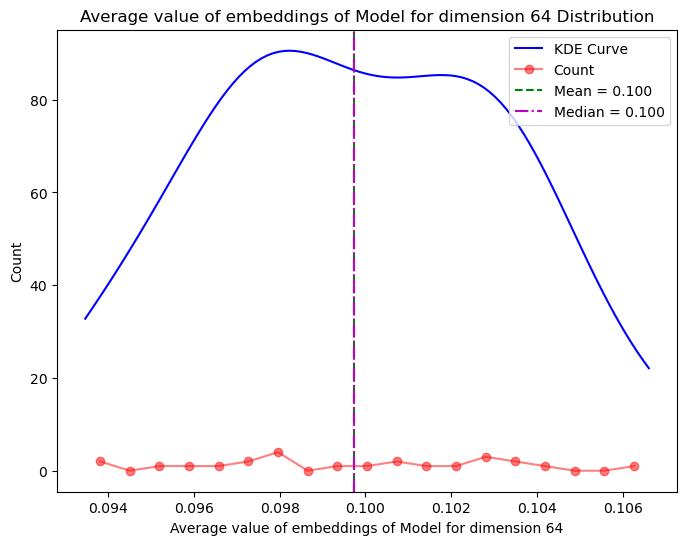

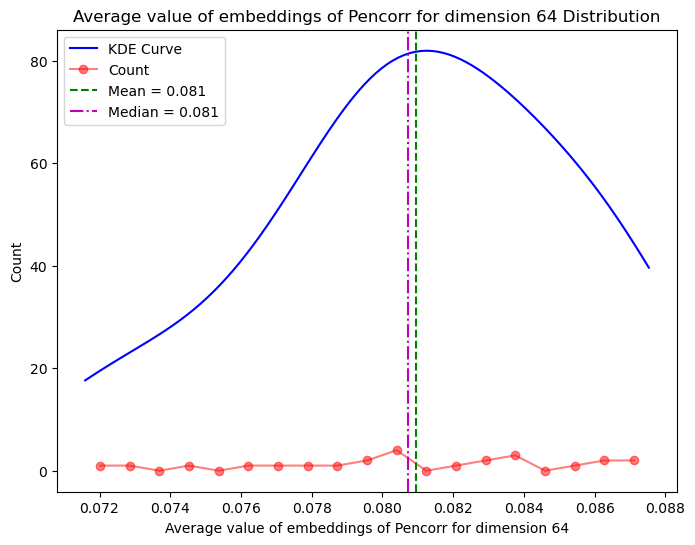

For dimension 128
[31, 195, 112, 82, 481, 80, 341, 447, 282, 243, 393, 499, 70, 120, 377, 417, 249, 248, 474, 491, 150, 404, 251, 192]


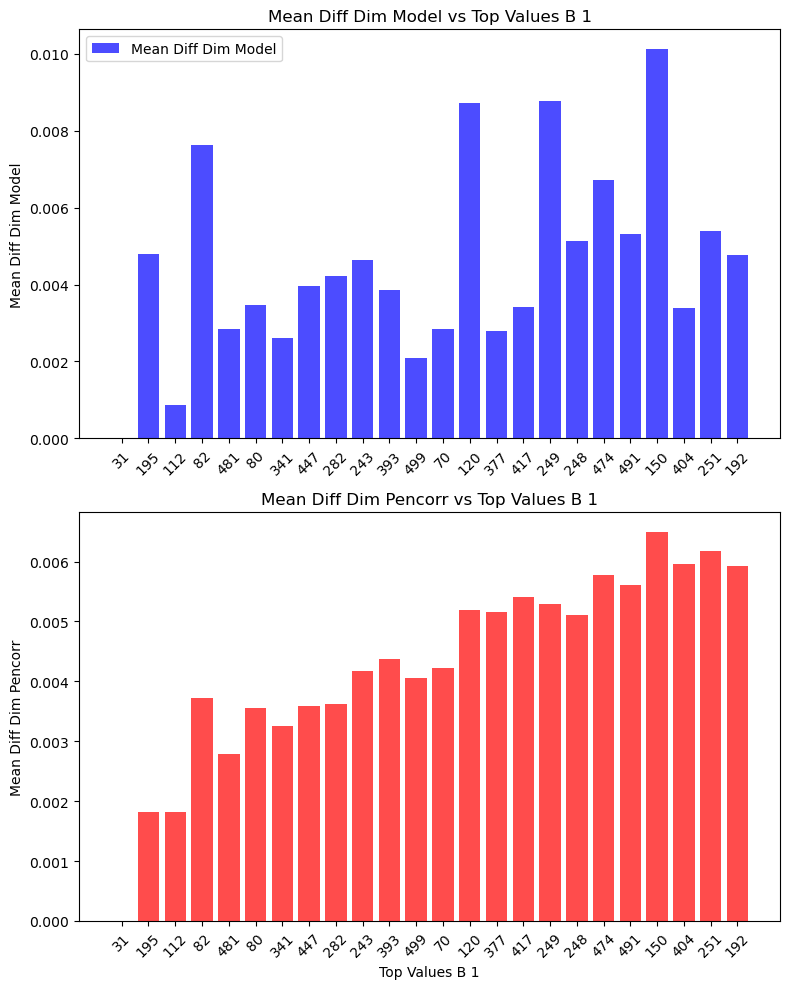

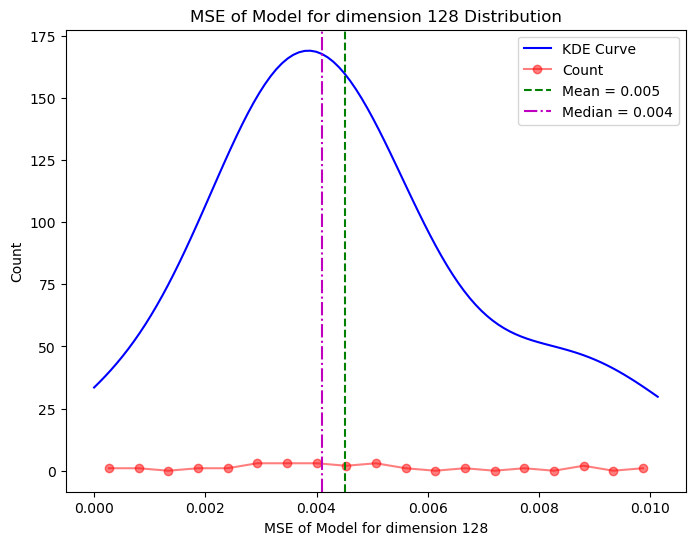

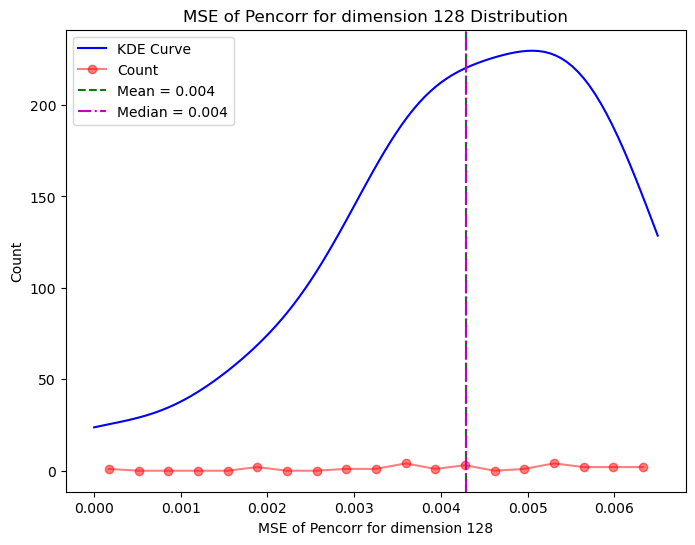

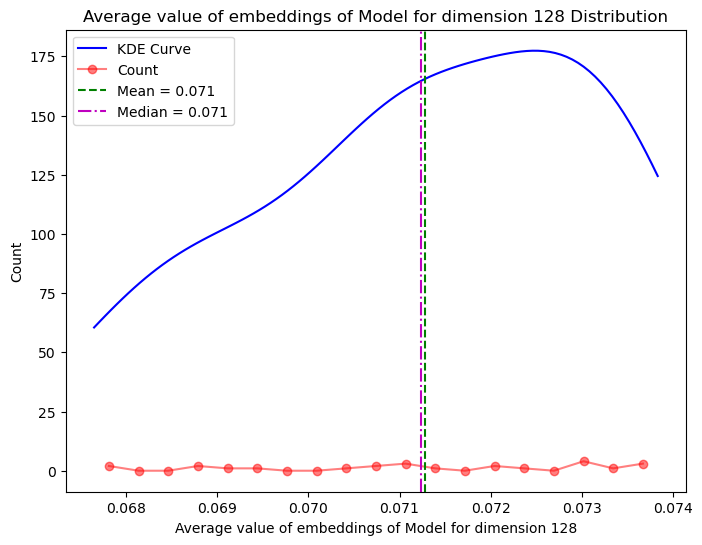

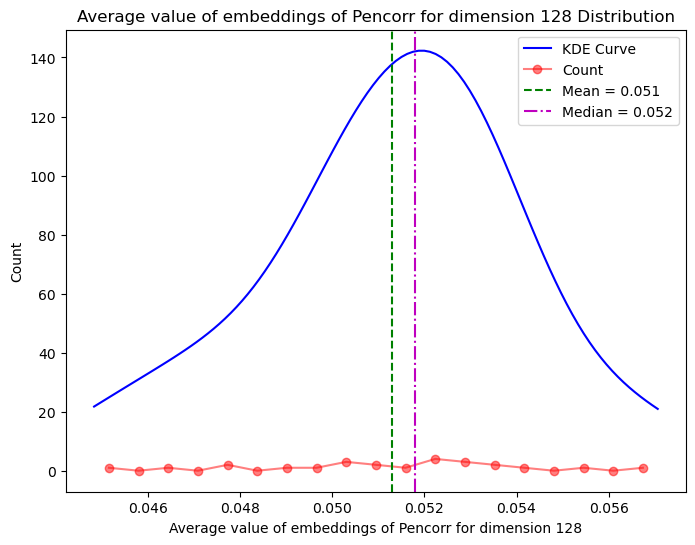

For dimension 256
[31, 195, 112, 82, 481, 80, 341, 447, 282, 243, 393, 499, 70, 120, 377, 417, 249, 248, 474, 491, 150, 404, 251, 192]


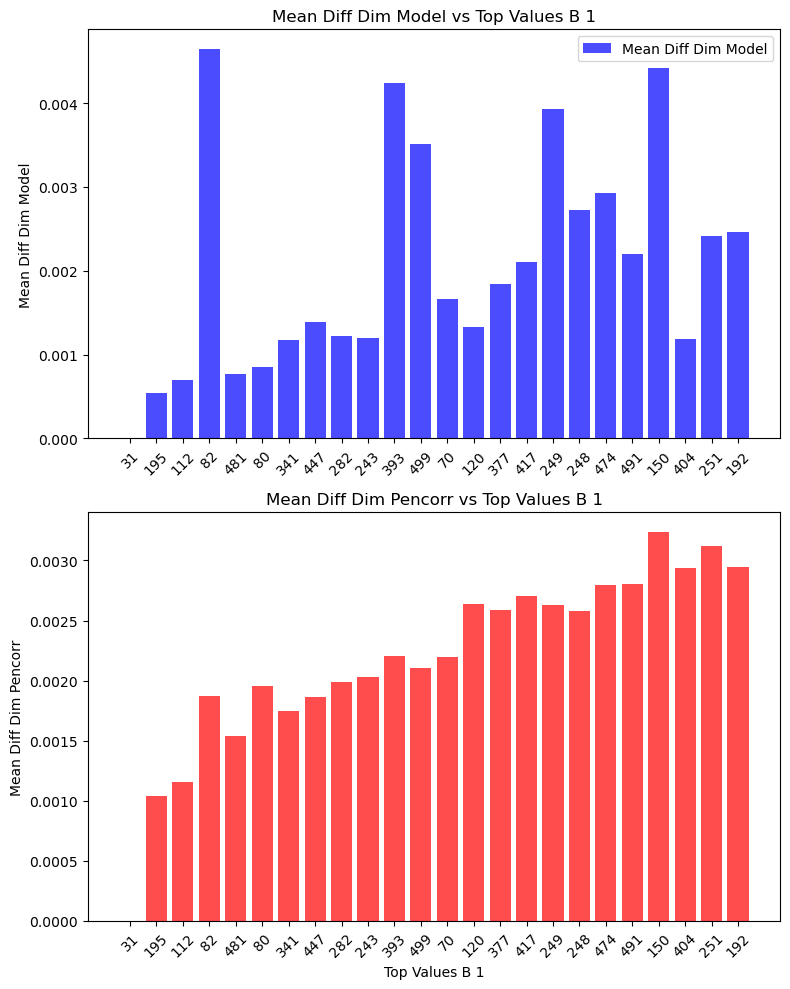

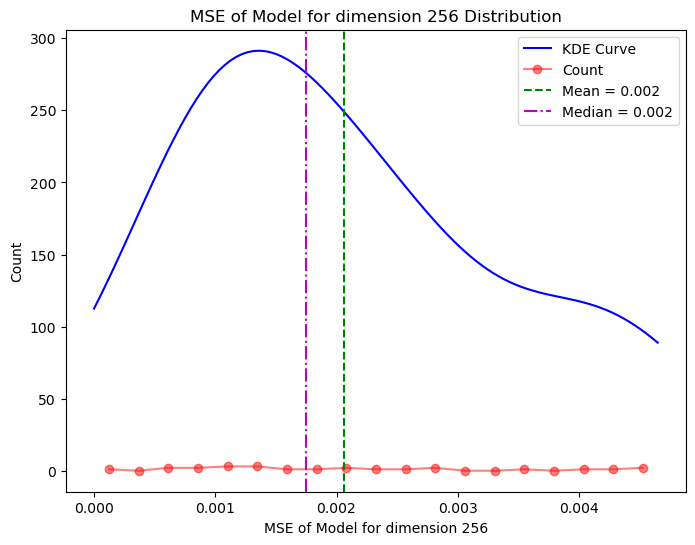

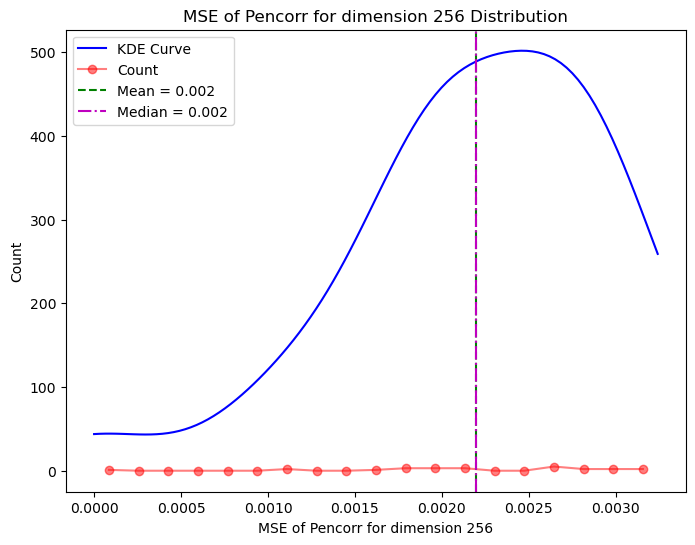

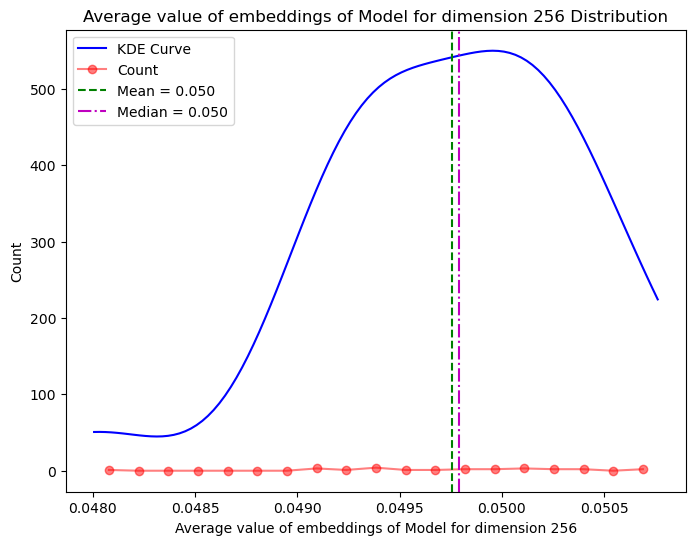

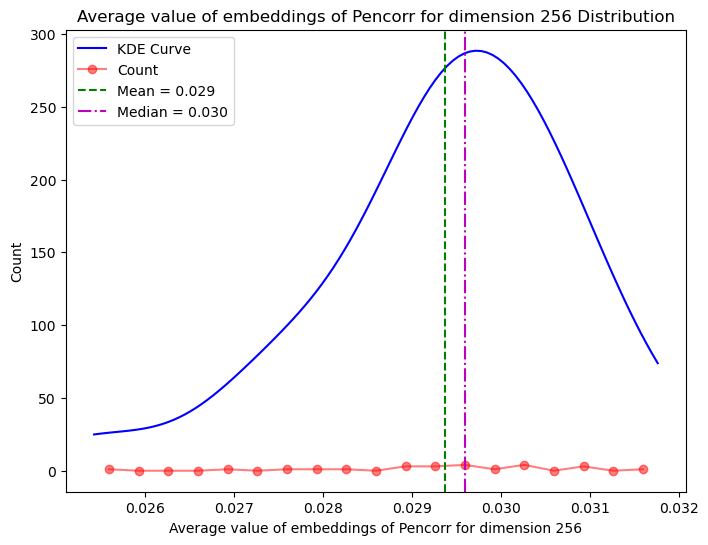

In [ ]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

## Visualisation of vector embeddings of different images across dimensions 

For dimension 32


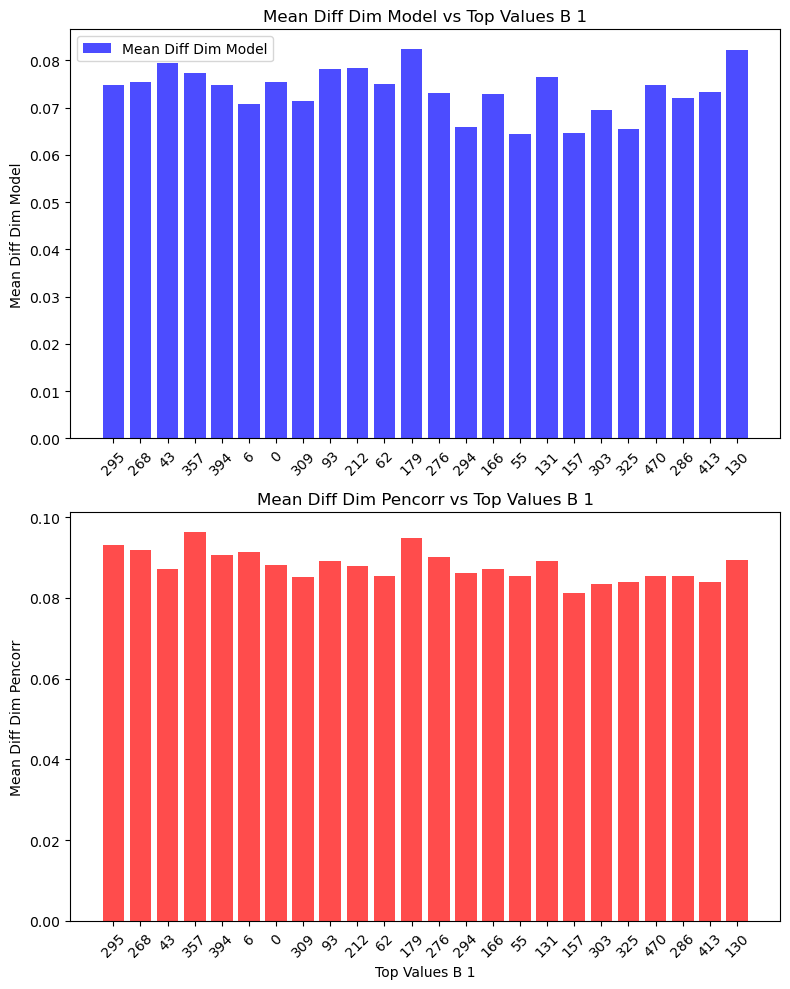

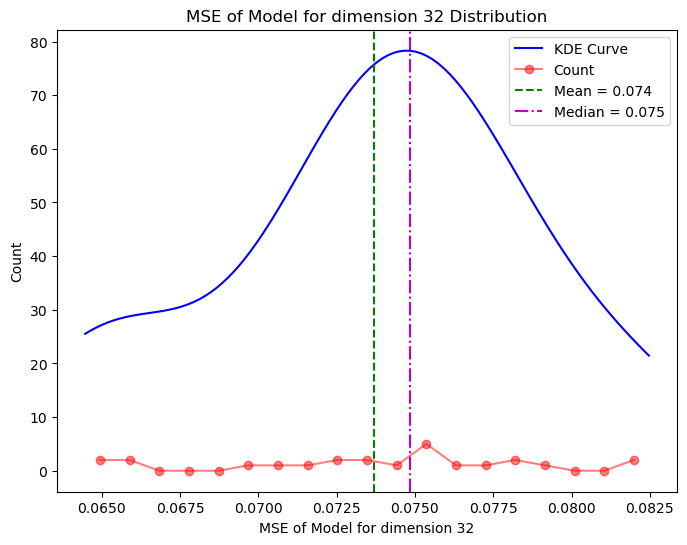

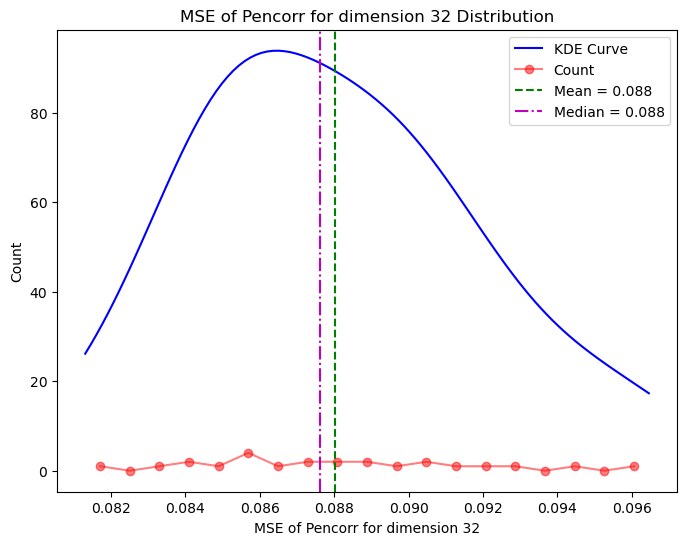

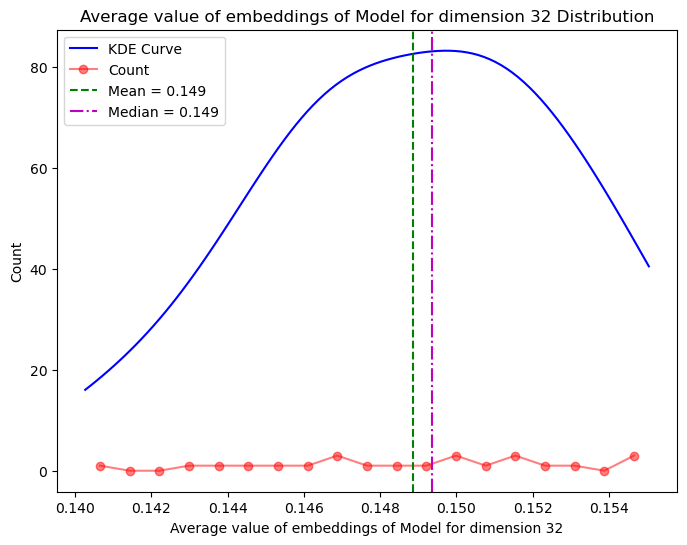

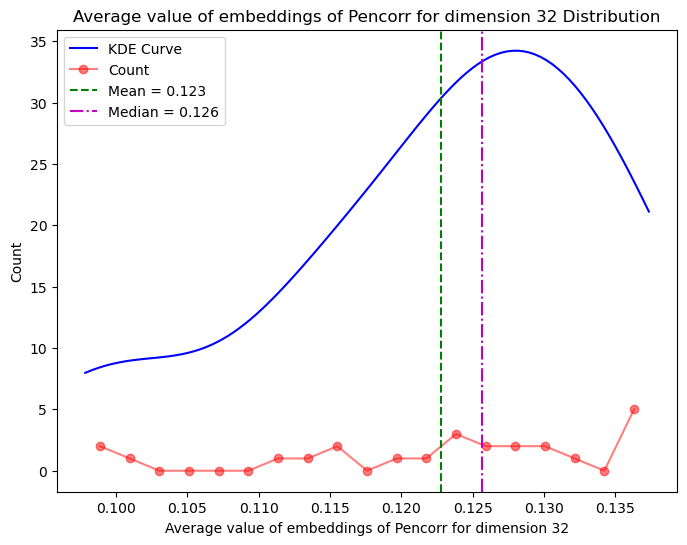

For dimension 64


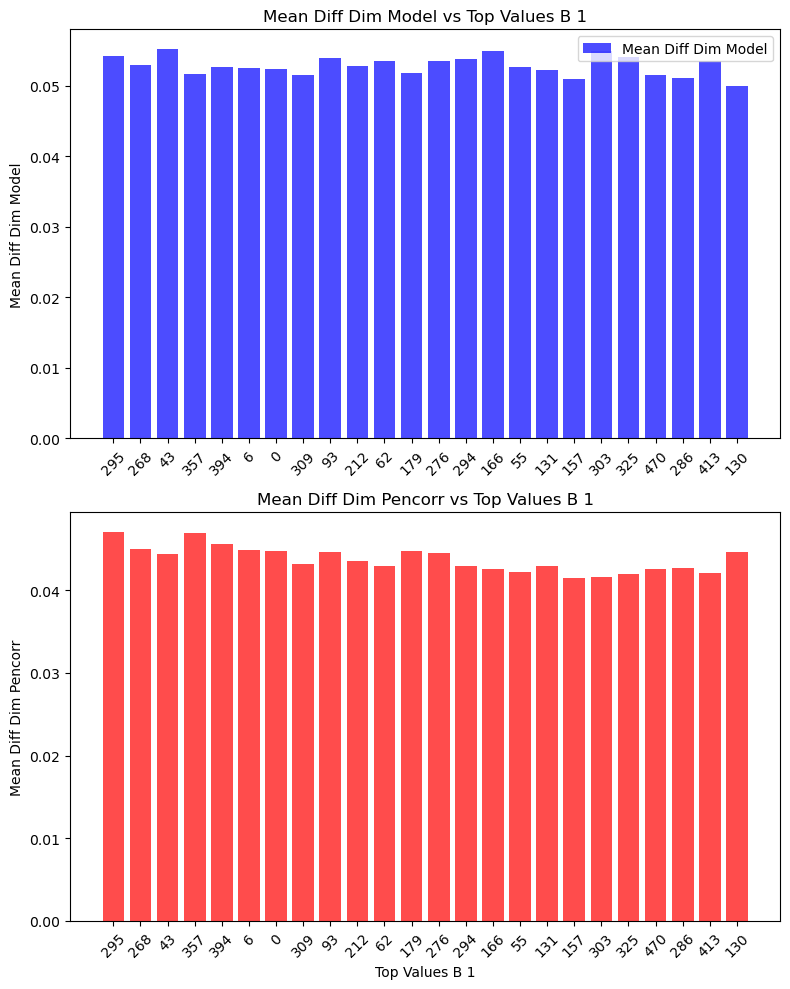

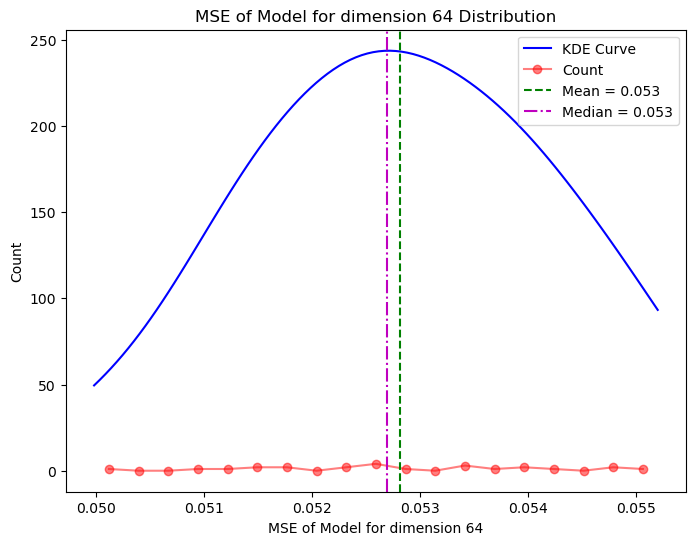

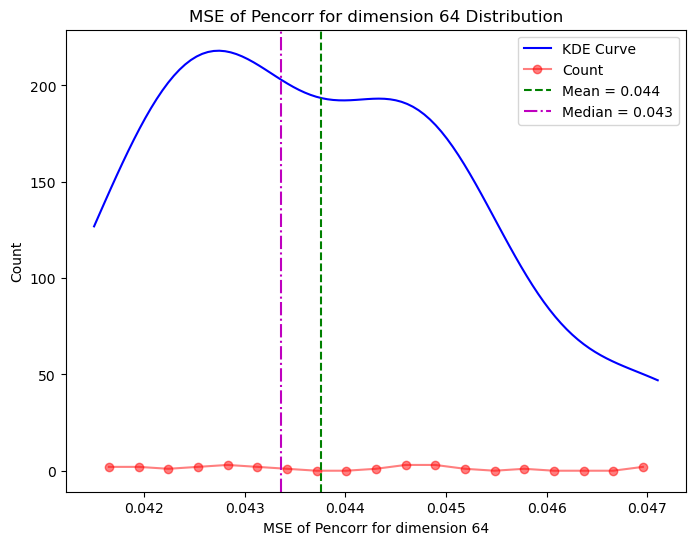

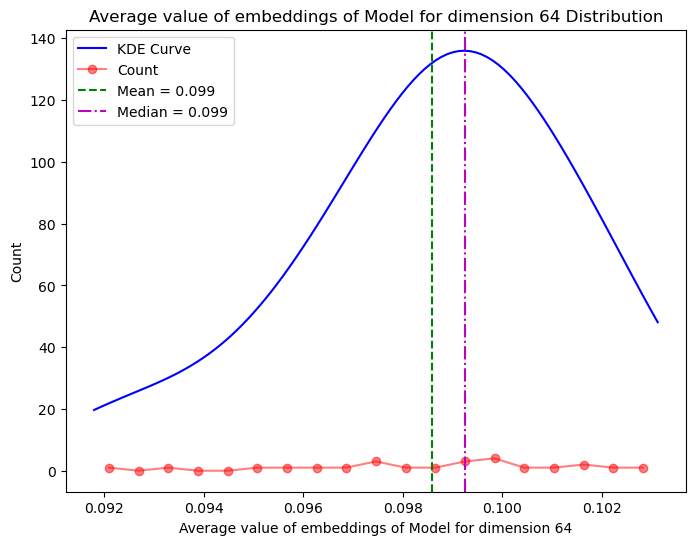

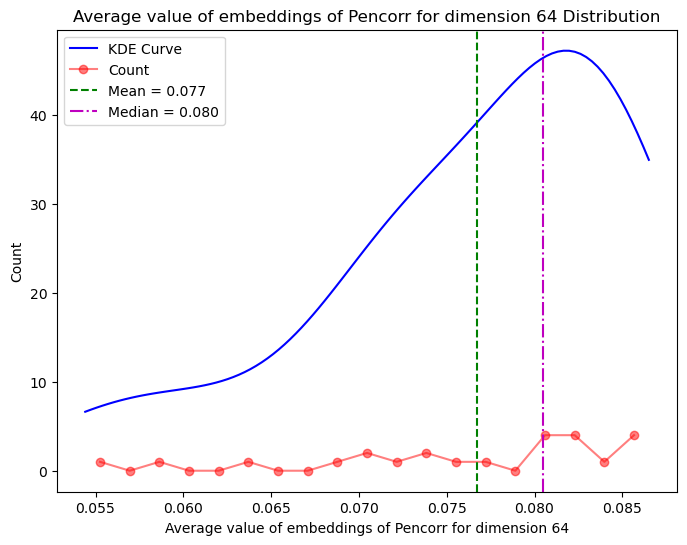

For dimension 128


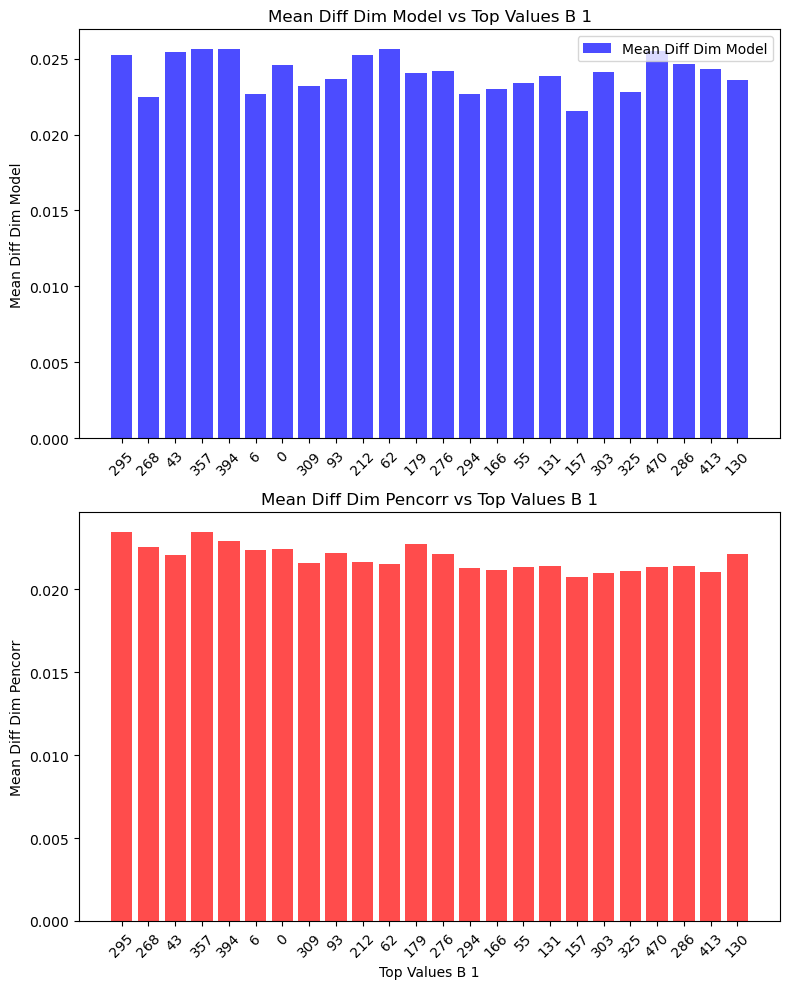

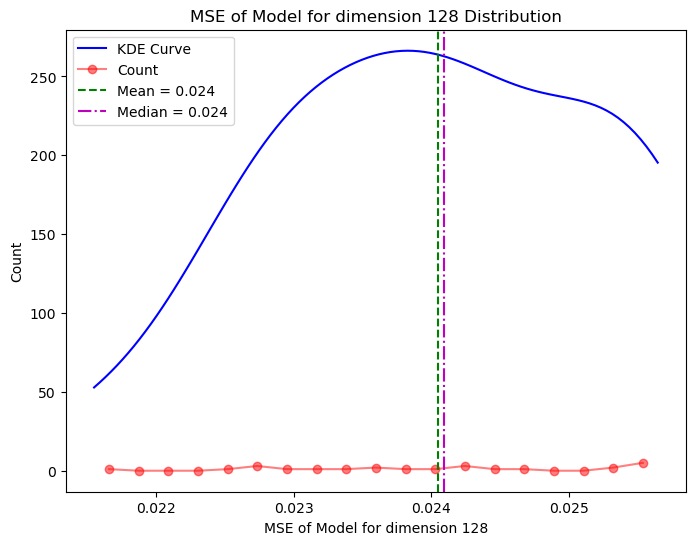

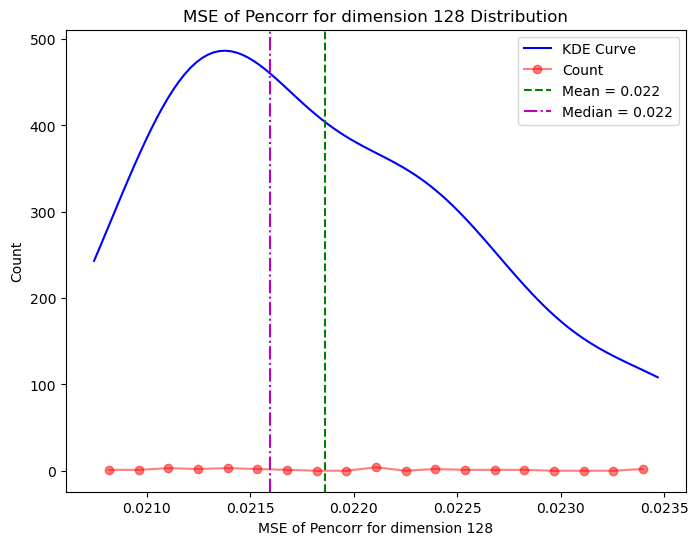

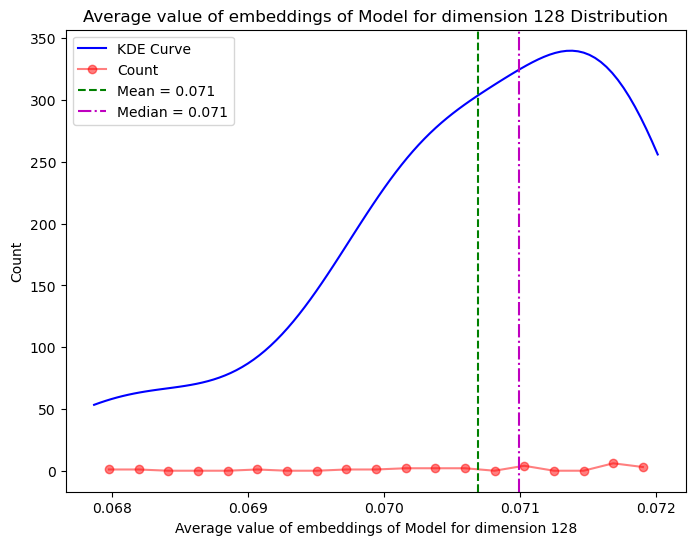

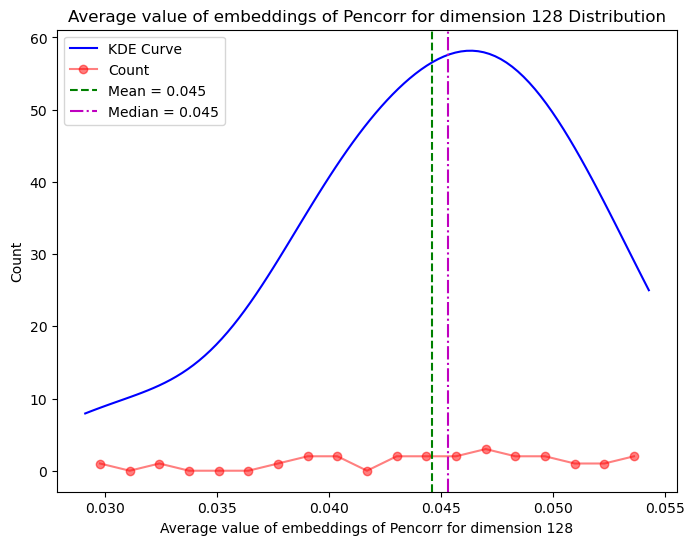

For dimension 256


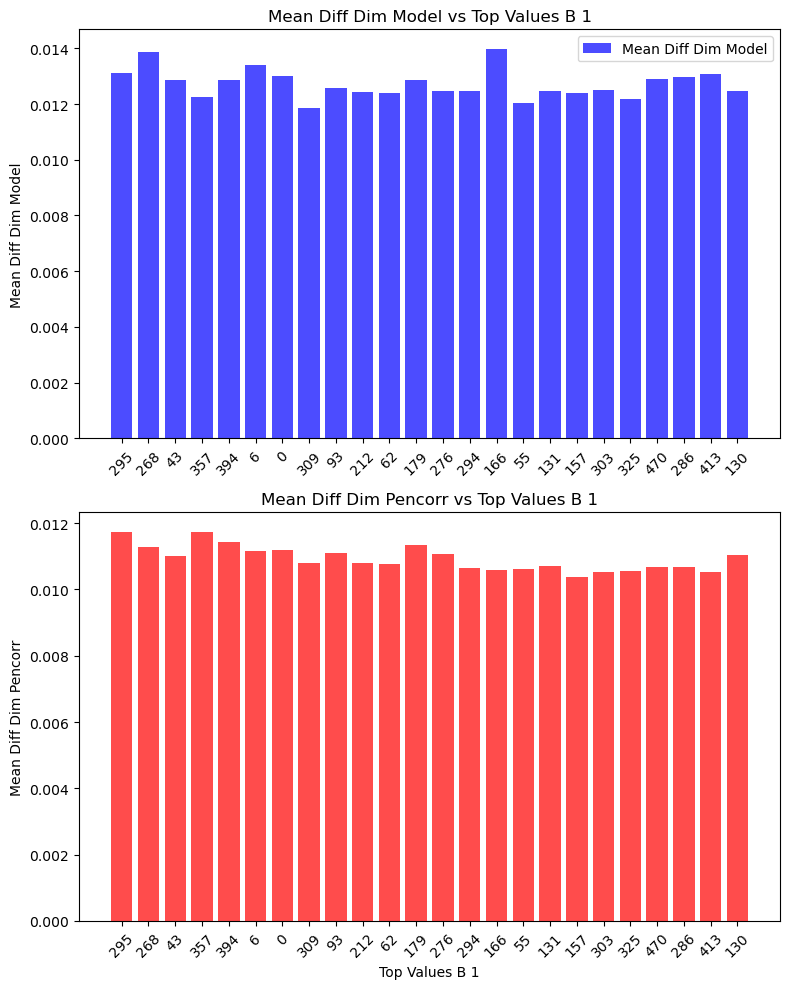

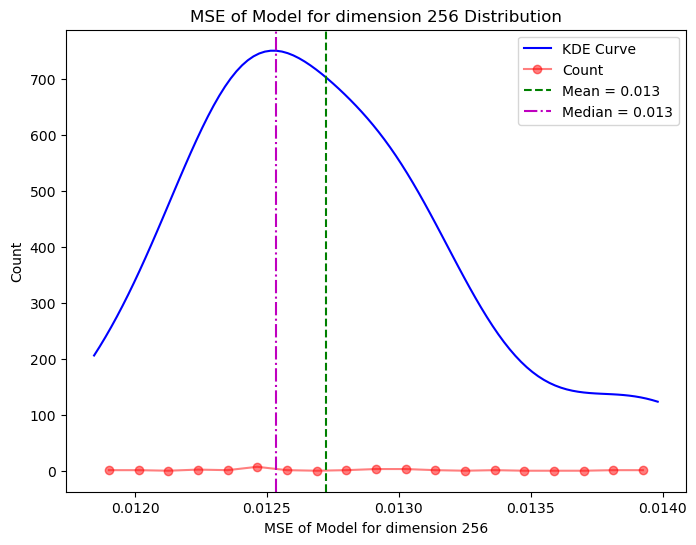

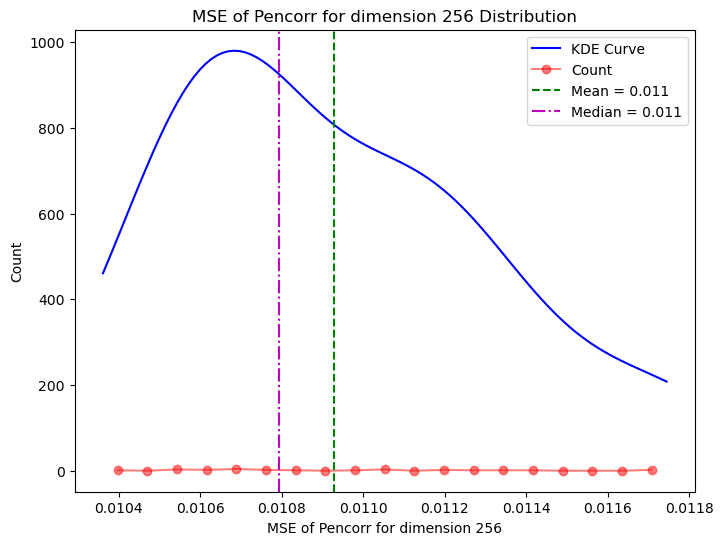

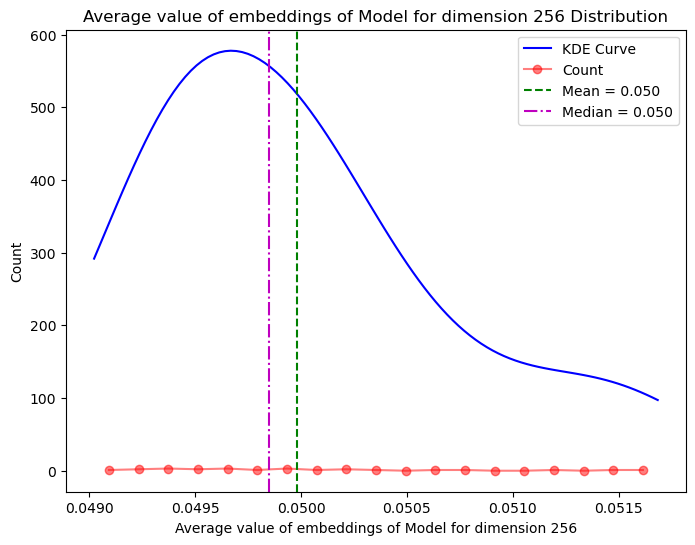

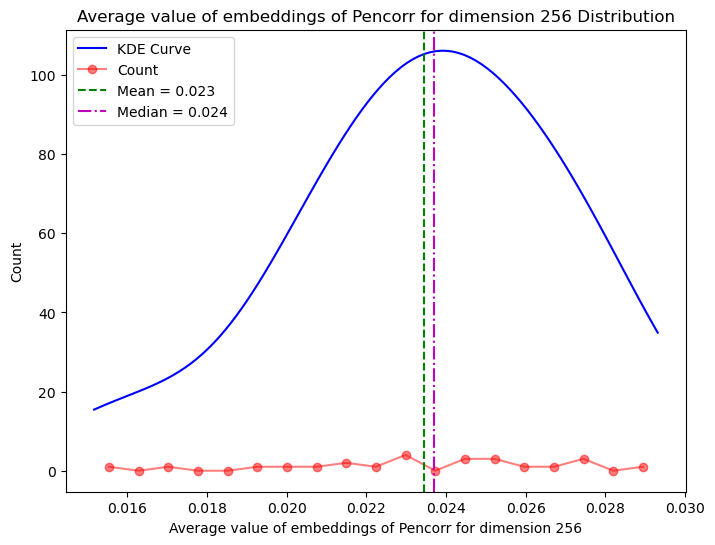

In [ ]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

## Metric 4
### Calculation of F1 Score across dimension using original vectors

In [8]:
#F1 score calculation per dimension
dimensions = [32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_2", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[j].detach().cpu().numpy())
            # if i ==1 and j == 1:
            #     print(mean_squared_difference, MSD_threshold)
            #     print(f"Embedding of similar image {i} for Model: {model_vectors[i]}")
            #     print(f"Embedding of similar image {j} for Model: {model_vectors[j]}")
            #     print(f"\nEmbedding of image {i} for Pencorr (A'A): {matrixA[:,i]}")
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 32
F1 Score: 8.0250 for dimension 32
For dimension 64
F1 Score: 8.0366 for dimension 64
For dimension 128
F1 Score: 6.3837 for dimension 128
For dimension 256
F1 Score: 6.0997 for dimension 256


### Calculation of F1 Score across dimension using transformed vectors from Orthogonal Procrustes

In [12]:
#F1 score calculation per dimension
dimensions = [32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_2", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_transformed[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[j].detach().cpu().numpy())
            # if i ==1 and j == 1:
            #     print(mean_squared_difference, MSD_threshold)
            #     print(f"Embedding of similar image {i} for Model: {model_vectors[i]}")
            #     print(f"Embedding of similar image {j} for Model: {model_vectors[j]}")
            #     print(f"\nEmbedding of image {i} for Pencorr (A'A): {matrixA[:,i]}")
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 32
F1 Score: 21.7927 for dimension 32
For dimension 64
F1 Score: 16.0839 for dimension 64
For dimension 128
F1 Score: 11.9789 for dimension 128
For dimension 256
F1 Score: 9.3600 for dimension 256


### Visualisation of Mean Squared Difference of transformed vector embeddings of sampled images -- Orthogonal Procrustes

In [8]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
     

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Transformed Model: {mean_squared_difference}")

# magnitude = np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# print("magnitude: ", magnitude)
# vector = model_transformed[index1].detach().cpu().numpy()/magnitude
# print("vector after normalisation: ", vector)

# mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], vector)
# print(f"Mean Squared Difference of Pencorr (A) and Normalised TransformedModel: {mean_squared_difference}")
# magnitude = np.linalg.norm(vector)
# print("magnitude: ", magnitude)

Difference between matrices

Mean Squared Difference of Model and NCC (G): 0.11956805100670481
Mean Squared Difference of Model and Pencorr (A'A): 0.11231446932154523

Printing matrices after transformation

Matrix G: [[ 1.          0.33333337  0.7320509  ... -0.15983188 -0.15983188
  -0.24407101]
 [ 0.33333337  1.          0.7320509  ... -0.15983188 -0.15983188
  -0.24407107]
 [ 0.7320509   0.7320509   1.         ... -0.02985746 -0.02985746
  -0.12712848]
 ...
 [-0.15983188 -0.15983188 -0.02985746 ...  1.          0.64705884
   0.58776844]
 [-0.15983188 -0.15983188 -0.02985746 ...  0.64705884  1.
   0.48191714]
 [-0.24407101 -0.24407107 -0.12712848 ...  0.58776844  0.48191714
   1.        ]]

Matrix A'A (Pencorr): [[ 1.          0.30870054  0.63502134 ... -0.12332915 -0.10612115
  -0.22349462]
 [ 0.30870054  1.          0.54878227 ... -0.15996517 -0.08644592
  -0.23666728]
 [ 0.63502134  0.54878227  1.         ... -0.01023721 -0.01046551
  -0.11487031]
 ...
 [-0.12332915 -0.15996517 -

### Visualisation of Mean Squared Difference of vector embeddings across dataset -- Orthogonal Procrustes


MSE between vector embeddings of Pencorr (A) and Model:


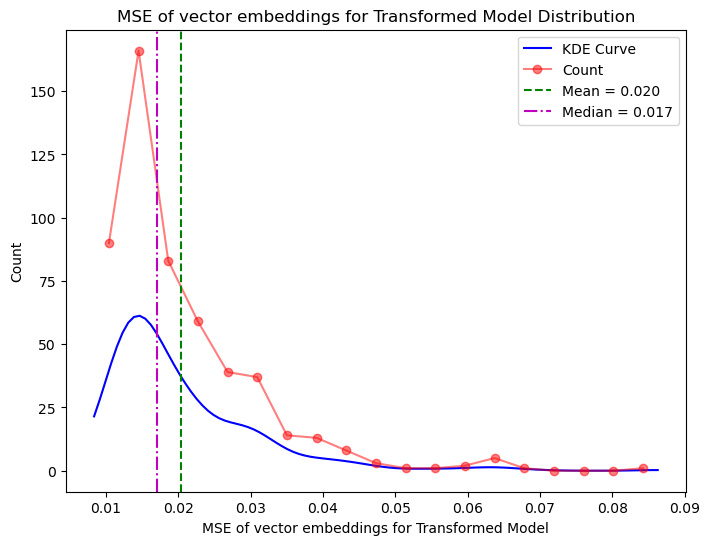

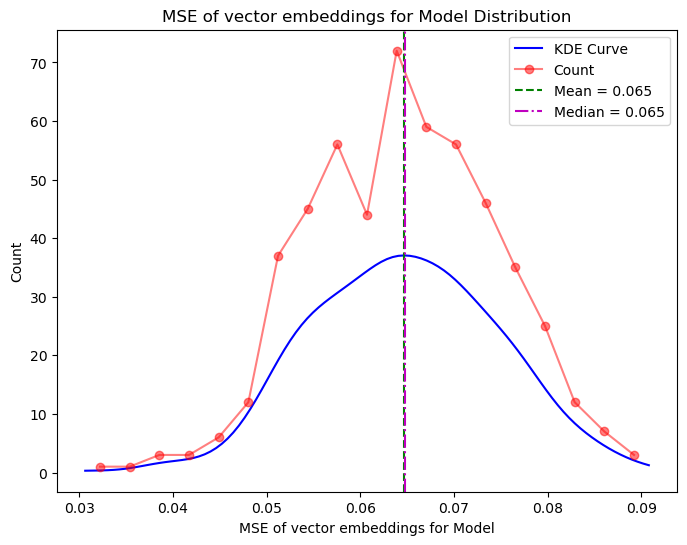

In [8]:
# ------------------------ MSE of embedding across dataset -----------------------------
num = len(input_dataset)
MSE_transformed = []
MSE_original = []
print(f"\nMSE between vector embeddings of Pencorr (A) and Model:")   
for i in range(num):
    mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
    #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
    MSE_transformed.append(mean_squared_difference)

    mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
    #print(f"Original matrix of Index {i}: {mean_squared_difference}")
    MSE_original.append(mean_squared_difference)
    
imgplt.plot_score_distribution(MSE_transformed, "MSE of vector embeddings for Transformed Model")
imgplt.plot_score_distribution(MSE_original, "MSE of vector embeddings for Model")

## Metric 3 
### Visualisation of Mean Squared Difference of vector embeddings, original and transformed using Orthogonal Procrustes, across dataset across dimensions


MSE between vector embeddings of dimension 32 for Pencorr (A) and Model:


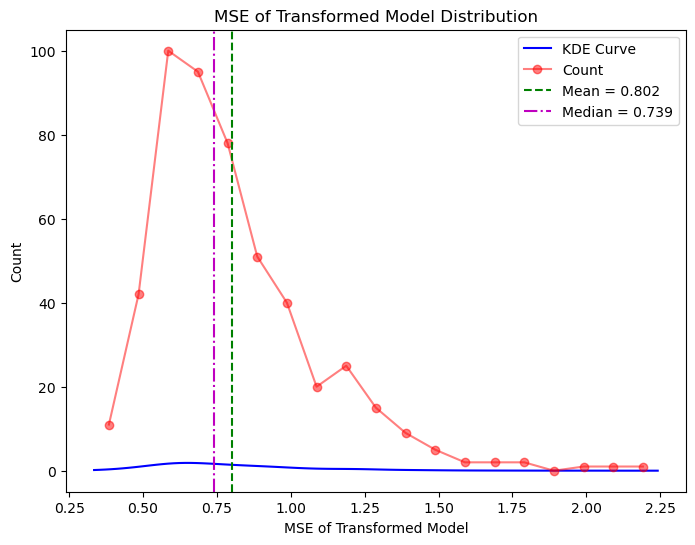

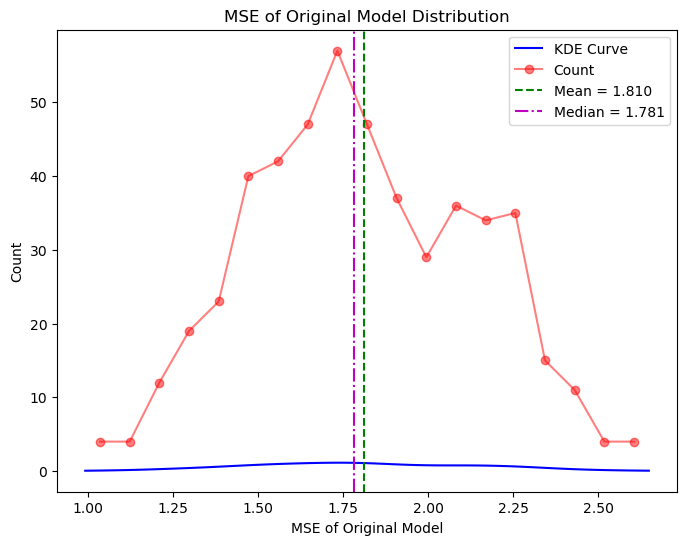


MSE between vector embeddings of dimension 64 for Pencorr (A) and Model:


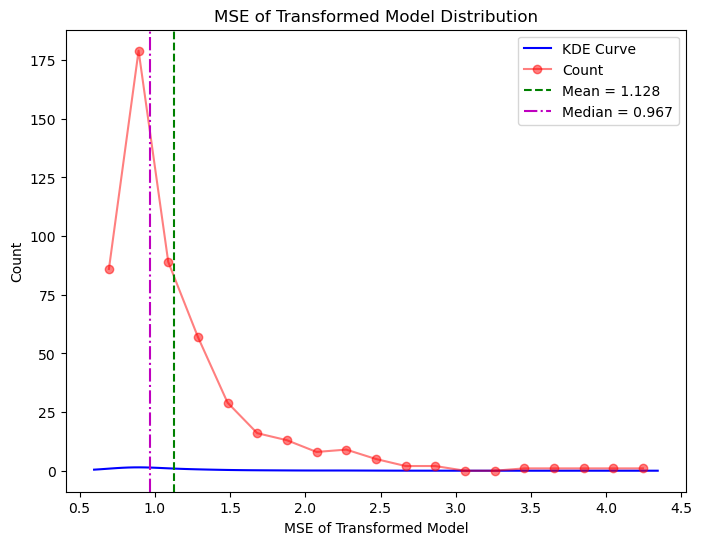

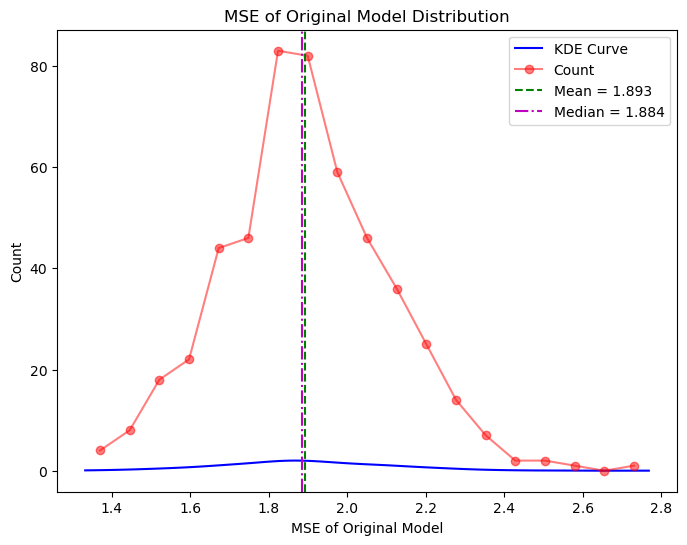


MSE between vector embeddings of dimension 128 for Pencorr (A) and Model:


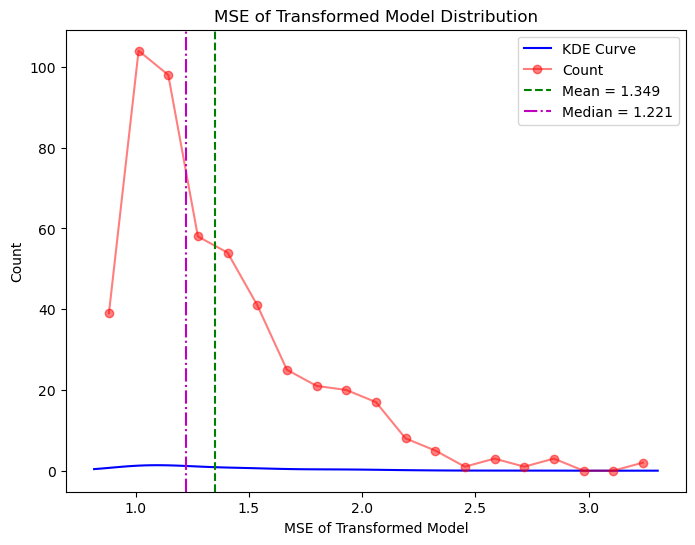

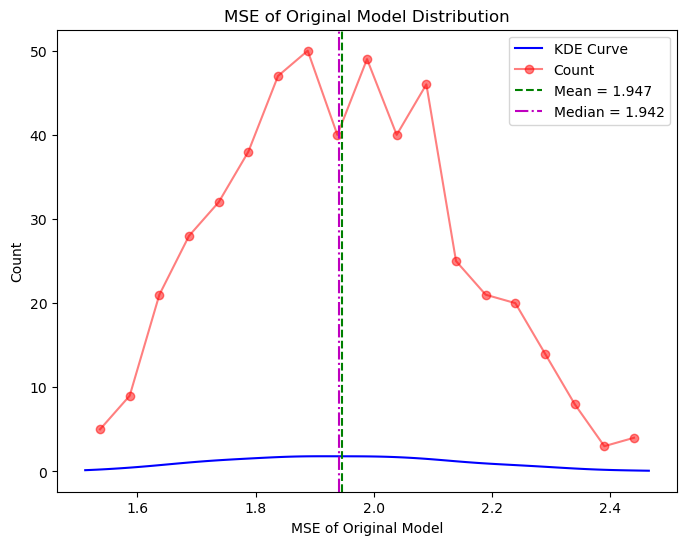


MSE between vector embeddings of dimension 256 for Pencorr (A) and Model:


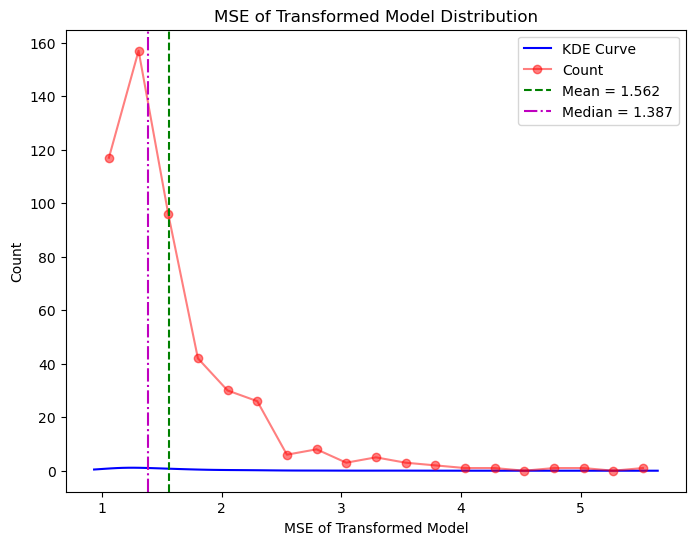

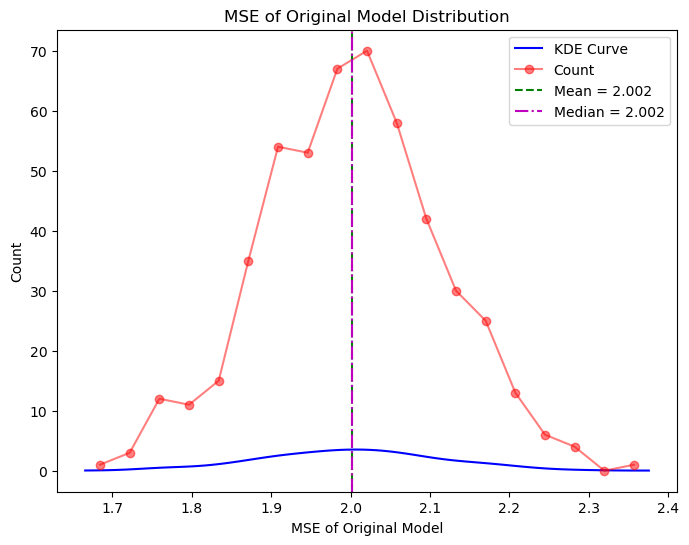

In [14]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed = []
MSD_original = []
    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_2", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    # find a fair way to compare across the dimensions,
        # maybe can experiment with the different angles 
    MSE_transformed = []
    MSE_original = []
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Model:")   
    for i in range(num):
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_transformed.append(np.mean(MSE_transformed))
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

## Obtaining the optimal dimension using 4 different metrics above

In [15]:
from collections import Counter
dimensions = [32, 64, 128, 256]

metric1 = np.argmax(k_score)
metric2 = np.argmin(mean)
metric3A = np.argmin(MSD_original)
metric3B = np.argmin(MSD_transformed)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric3B],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 64


## Calculating transformed embedding using Orthogonal Procustes for the optimal embedding dimension using metric 1 and 2

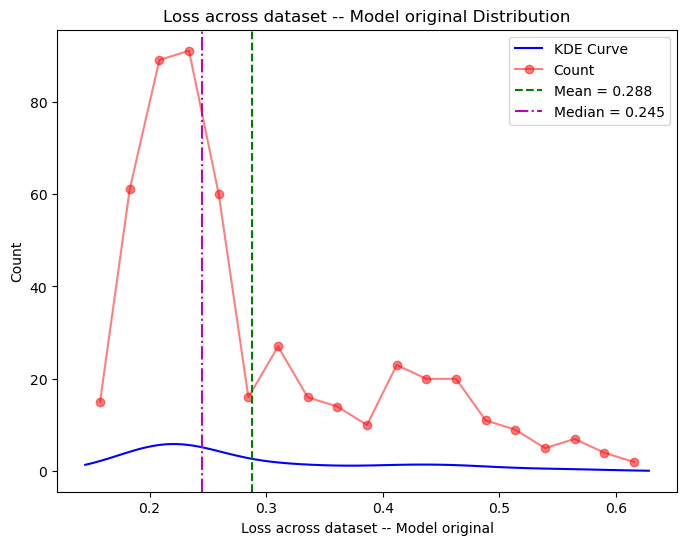

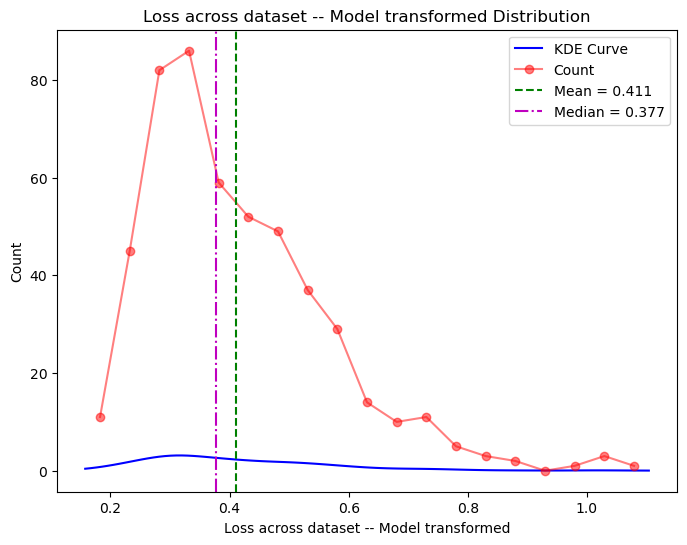

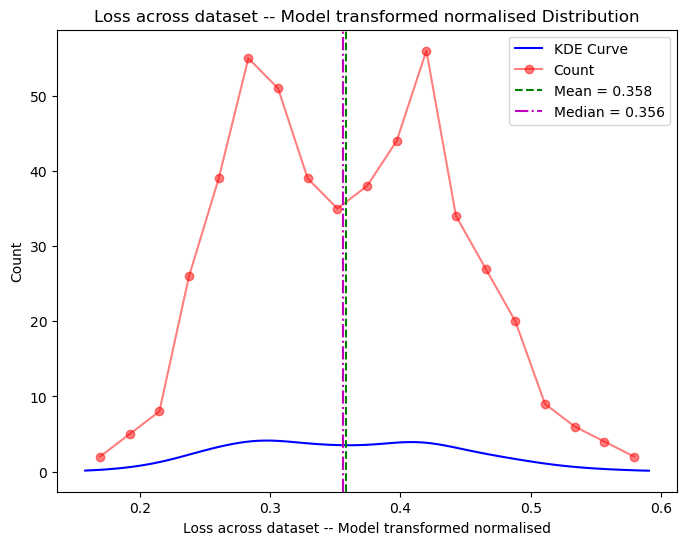

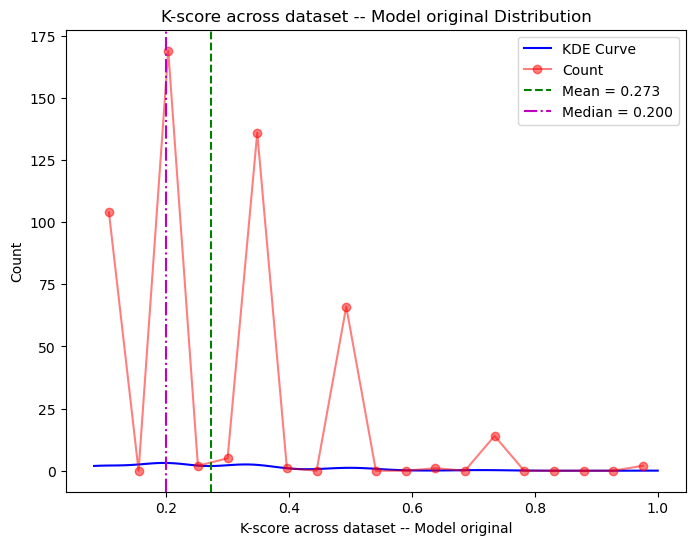

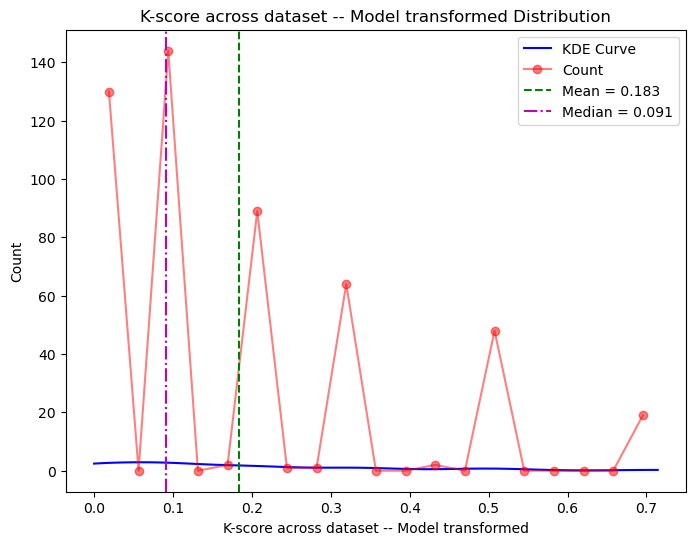

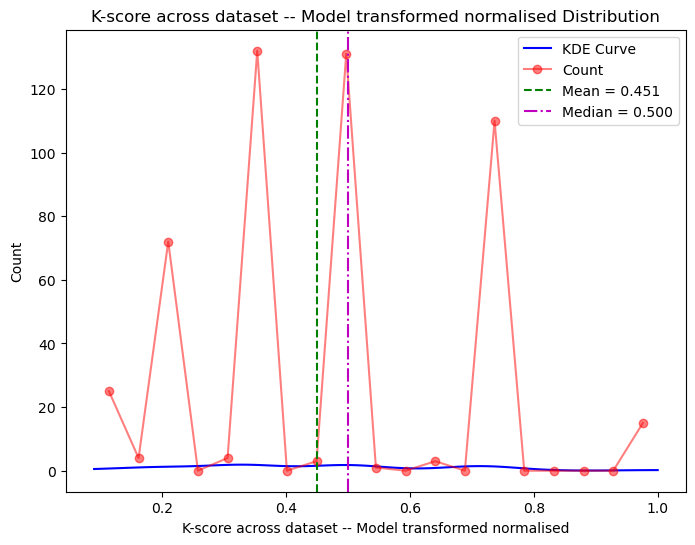

In [16]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
loss_transformed_normalised = []
loss_transformed = []
loss_original = []
kscore_transformed_normalised = []
kscore_transformed = []
kscore_original = []

dim = optimal_dim 
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

for i in range(num):
        vectorb = imgcalc.get_vectorb_model(i, model, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
            
            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)
            
            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])
            
            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)
    
        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
    
imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")

In [ ]:
# -------------------- Using normalized embedding loss function to determine dimension--------------------
def find_optimal_dim(losses, eps=0.05): 
    """ losses: dict {dimension: L(d)} """
    L_inf = min(losses.values()) 
    for d in sorted(losses.keys()): 
        if (losses[d] - L_inf)/L_inf <= eps: 
            return d 
    return max(losses.keys())


In [7]:
# -------------- mega insane debug -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 154
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than tolerance: 154

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.159